In [1]:
import pickle
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import json
import re
from shapely.geometry import Point, LineString #this library is for manipulating geometric objects, and it is what geopandas uses to store geometries
from scipy.spatial import distance

## Part I: London’s underground resilience
### 1. Topological network
#### 1.1. Centrality measures:

In [2]:
with open('London_tube_network_cl.pkl/London_tube_network_cl.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 401
Number of edges: 467


In [4]:
# To check edges attributes:
list(G.edges(data = True))[0]

('Edgware',
 'Burnt Oak',
 {'length': 1518.1144792538078, 'line_name': 'Northern'})

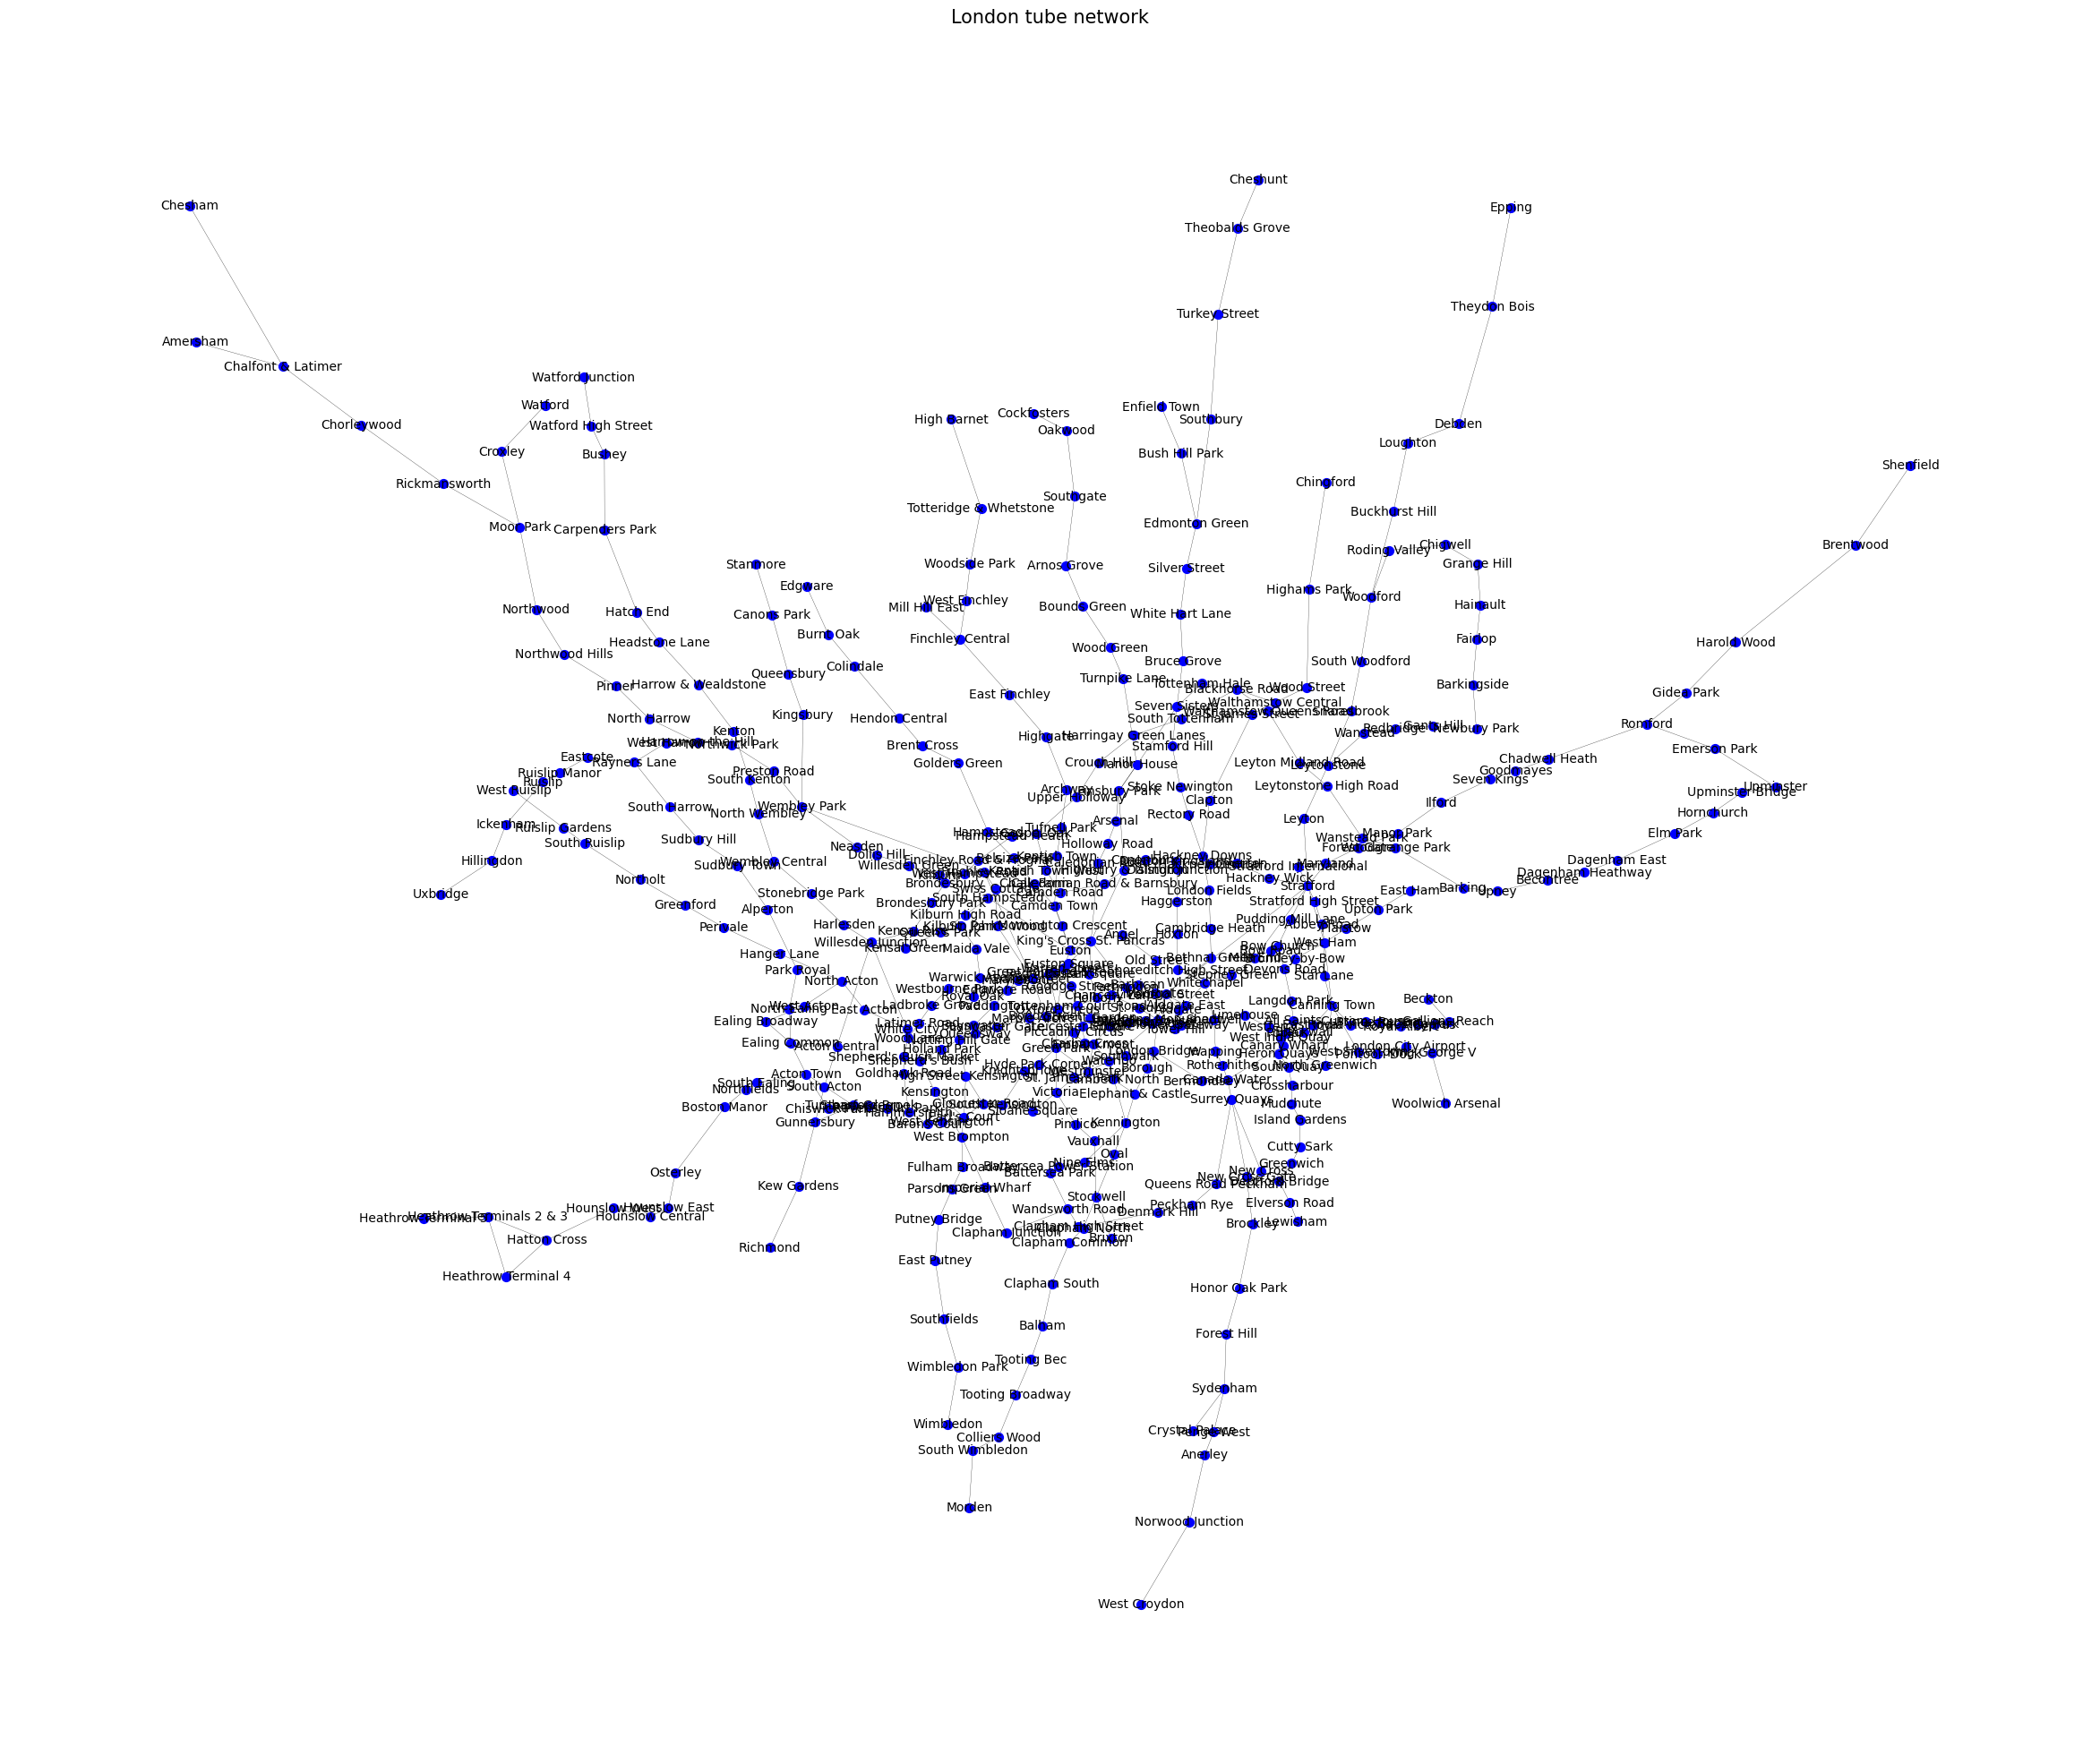

In [5]:
# We can plot the tube network with the names of the stations as labels
fig, ax = plt.subplots(figsize=(30,25))

node_labels = {node: node for node in G.nodes()} 

pos = nx.get_node_attributes(G, 'coords')

nx.draw_networkx_nodes(G,pos,node_size=50,node_color='b')
nx.draw_networkx_edges(G,pos,arrows=False,width=0.2)
nx.draw_networkx_labels(G,pos, node_labels, font_size=10, font_color='black')

plt.title("London tube network",fontsize=15)
plt.axis("off")
plt.show()

In [6]:
# Degree Centrality
deg = nx.degree_centrality(G)
nx.set_node_attributes(G, deg, 'degree')

# Closeness Centrality
clo = nx.closeness_centrality(G)
nx.set_node_attributes(G, clo, 'closeness')

# Betweenness Centrality
bet = nx.betweenness_centrality(G)
nx.set_node_attributes(G, bet, 'betweenness')

# df
df = pd.DataFrame({
    'station': list(G.nodes),
    'degree': [deg[n] for n in G.nodes],
    'closeness': [clo[n] for n in G.nodes],
    'betweenness': [bet[n] for n in G.nodes],
    'num_links': [G.degree[n] for n in G.nodes],
})

#s ort top 10
top_degree = df.sort_values(by='degree', ascending=False).head(10)
top_closeness = df.sort_values(by='closeness', ascending=False).head(10)
top_betweenness = df.sort_values(by='betweenness', ascending=False).head(10)

print("Top 10 Degree Centrality")
display(top_degree)

print("Top 10 Closeness Centrality")
display(top_closeness)

print("Top 10 Betweenness Centrality")
display(top_betweenness)

Top 10 Degree Centrality


station  degree  closeness  betweenness  num_links
180                 Stratford  0.0225   0.104384     0.297846          9
15          Bank and Monument  0.0200   0.113572     0.290489          8
62               Baker Street  0.0175   0.108962     0.191568          7
11   King's Cross St. Pancras  0.0175   0.113443     0.255307          7
61           Liverpool Street  0.0150   0.110254     0.270807          6
231              Canning Town  0.0150   0.091575     0.096167          6
127                Green Park  0.0150   0.114778     0.215835          6
120             Oxford Circus  0.0150   0.111204     0.053844          6
90                   West Ham  0.0150   0.097823     0.139344          6
333              Earl's Court  0.0150   0.090416     0.125892          6

Top 10 Closeness Centrality


station  degree  closeness  betweenness  num_links
127                Green Park  0.0150   0.114778     0.215835          6
15          Bank and Monument  0.0200   0.113572     0.290489          8
11   King's Cross St. Pancras  0.0175   0.113443     0.255307          7
287               Westminster  0.0100   0.112549     0.203335          4
35                   Waterloo  0.0150   0.112265     0.243921          6
120             Oxford Circus  0.0150   0.111204     0.053844          6
309               Bond Street  0.0100   0.110988     0.141591          4
12                      Angel  0.0050   0.110742     0.064110          2
65                 Farringdon  0.0050   0.110742     0.064110          2
14                   Moorgate  0.0100   0.110314     0.130169          4

Top 10 Betweenness Centrality


station  degree  closeness  betweenness  num_links
180                 Stratford  0.0225   0.104384     0.297846          9
15          Bank and Monument  0.0200   0.113572     0.290489          8
61           Liverpool Street  0.0150   0.110254     0.270807          6
11   King's Cross St. Pancras  0.0175   0.113443     0.255307          7
35                   Waterloo  0.0150   0.112265     0.243921          6
127                Green Park  0.0150   0.114778     0.215835          6
10                     Euston  0.0125   0.109830     0.208324          5
287               Westminster  0.0100   0.112549     0.203335          4
62               Baker Street  0.0175   0.108962     0.191568          7
83              Finchley Road  0.0100   0.102617     0.165085          4

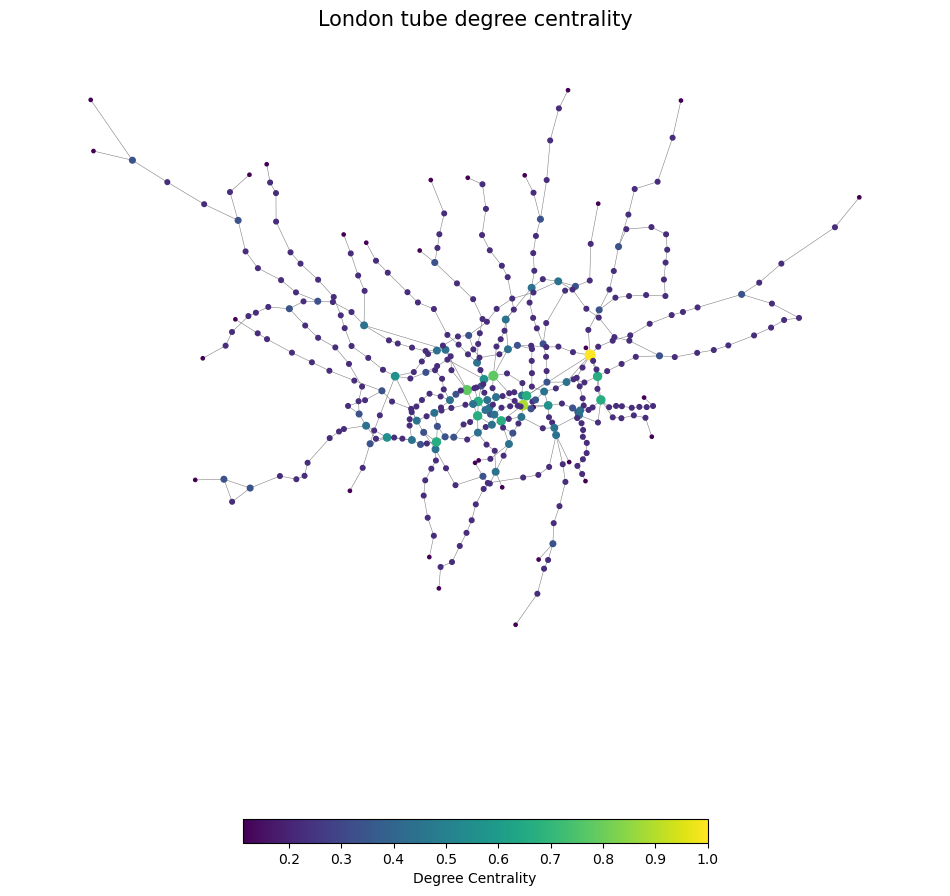

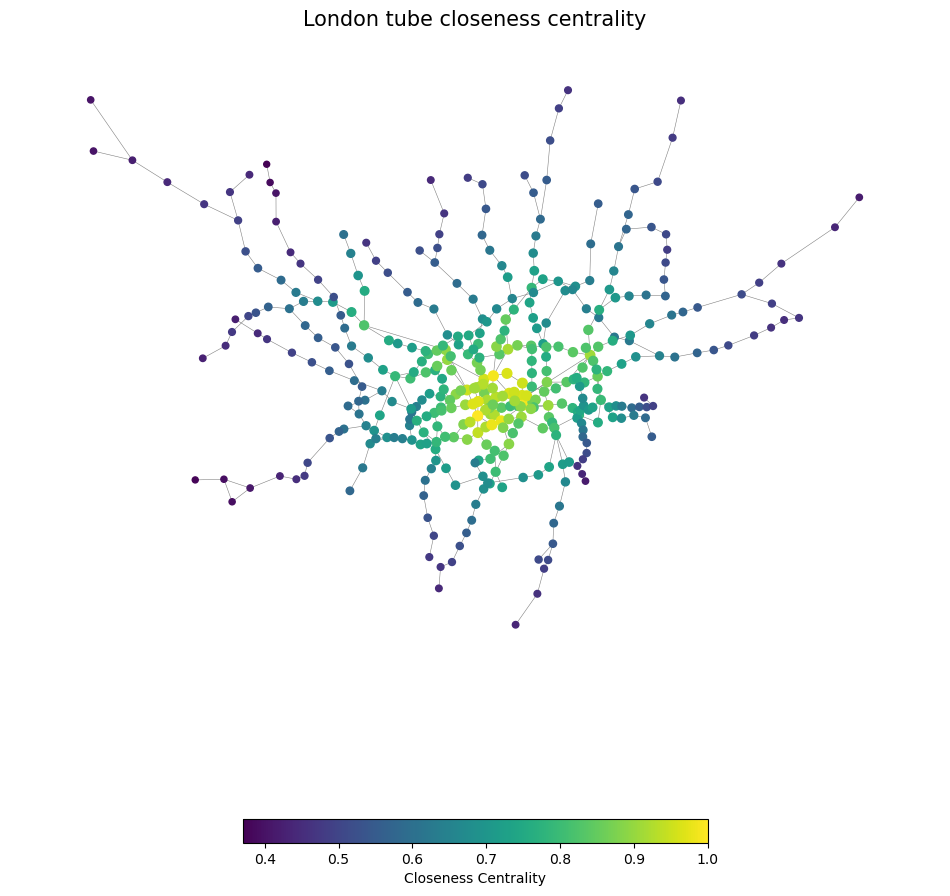

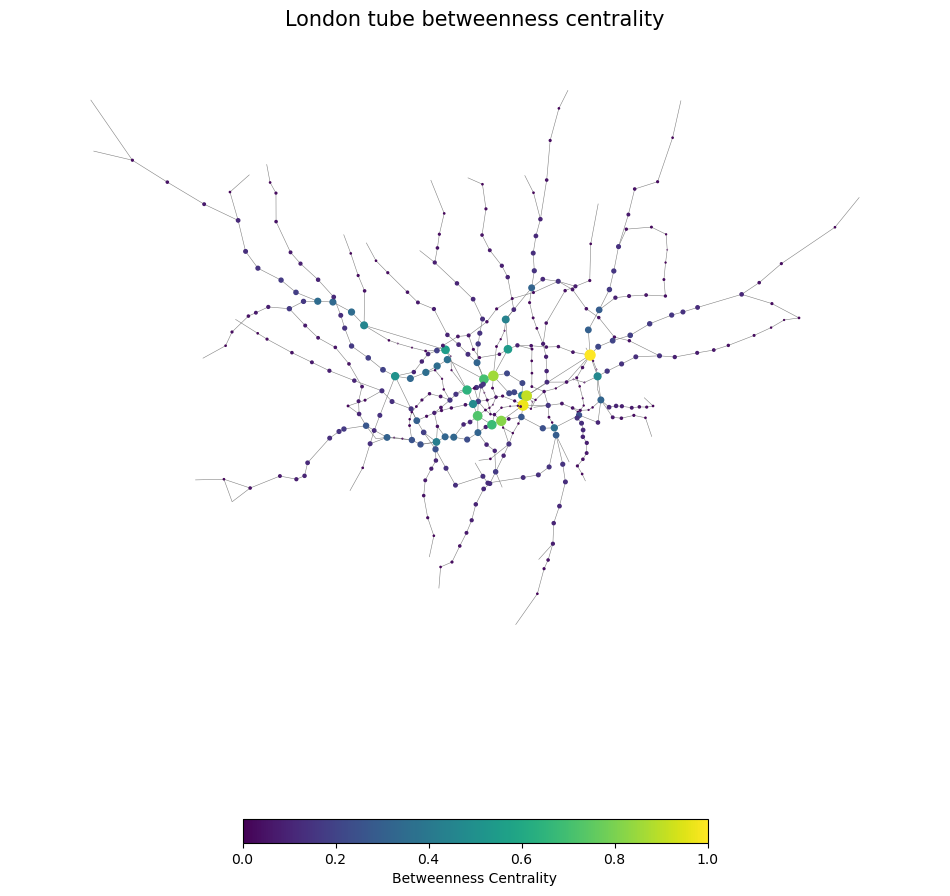

In [7]:
def plot_centrality(G, pos, centrality_name, scale=50, cmap='viridis'):
    values = [data[centrality_name] for _, data in G.nodes(data=True)]
    norm_values = [v / max(values) for v in values]
    sizes = [v * scale for v in norm_values]

    fig, ax = plt.subplots(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4)
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=norm_values,
        node_size=sizes,
        cmap=cmap
    )
    plt.colorbar(nodes, label=f"{centrality_name.capitalize()} Centrality", orientation="horizontal", shrink=0.5)
    plt.title(f"London tube {centrality_name} centrality", fontsize=15)
    plt.axis("off")
    plt.show()

plot_centrality(G, pos, 'degree')
plot_centrality(G, pos, 'closeness')
plot_centrality(G, pos, 'betweenness')

#### 1.2. Node removal

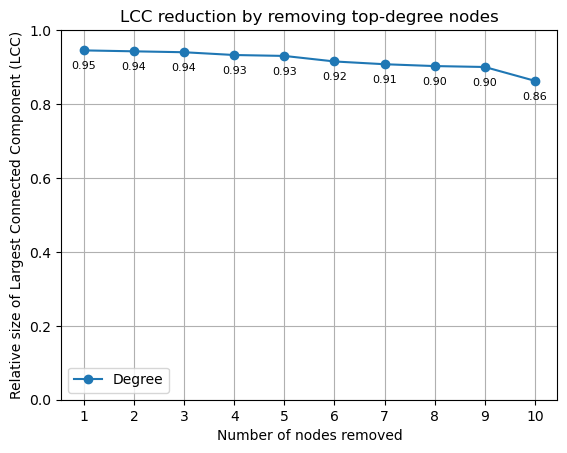

nodes_removed           station_removed  centrality_value  degree  \
0              1                 Stratford            0.0225       9   
1              2         Bank and Monument            0.0200       8   
2              3  King's Cross St. Pancras            0.0175       7   
3              4              Baker Street            0.0175       7   
4              5                  Waterloo            0.0150       6   
5              6          Liverpool Street            0.0150       6   
6              7                  West Ham            0.0150       6   
7              8             Oxford Circus            0.0150       6   
8              9                Green Park            0.0150       6   
9             10              Canning Town            0.0150       6   

   lcc_ratio  
0   0.945137  
1   0.942643  
2   0.940150  
3   0.932668  
4   0.930175  
5   0.915212  
6   0.907731  
7   0.902743  
8   0.900249  
9   0.862843

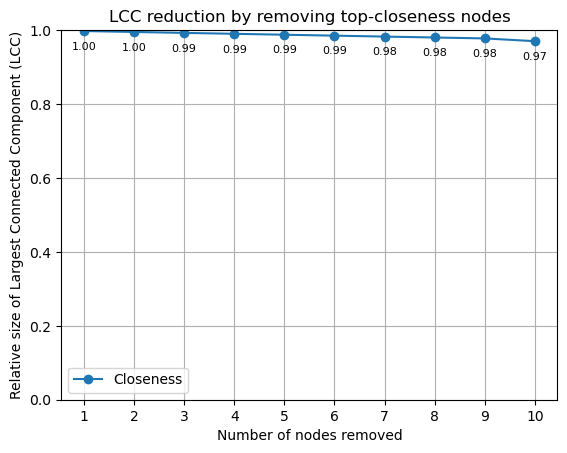

nodes_removed           station_removed  centrality_value  degree  \
0              1                Green Park          0.114778       6   
1              2         Bank and Monument          0.113572       8   
2              3  King's Cross St. Pancras          0.113443       7   
3              4               Westminster          0.112549       4   
4              5                  Waterloo          0.112265       6   
5              6             Oxford Circus          0.111204       6   
6              7               Bond Street          0.110988       4   
7              8                     Angel          0.110742       2   
8              9                Farringdon          0.110742       2   
9             10                  Moorgate          0.110314       4   

   lcc_ratio  
0   0.997506  
1   0.995012  
2   0.992519  
3   0.990025  
4   0.987531  
5   0.985037  
6   0.982544  
7   0.980050  
8   0.977556  
9   0.970075

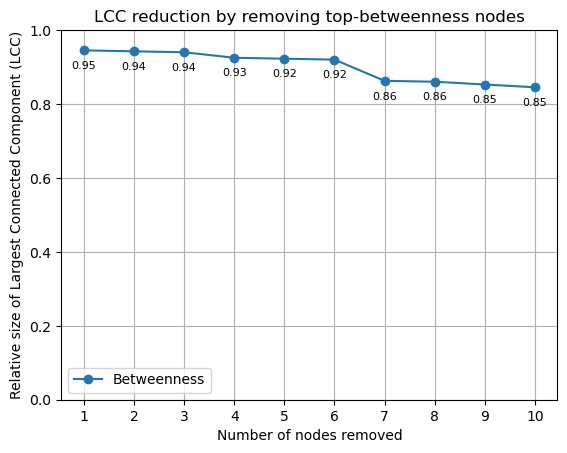

nodes_removed           station_removed  centrality_value  degree  \
0              1                 Stratford          0.297846       9   
1              2         Bank and Monument          0.290489       8   
2              3          Liverpool Street          0.270807       6   
3              4  King's Cross St. Pancras          0.255307       7   
4              5                  Waterloo          0.243921       6   
5              6                Green Park          0.215835       6   
6              7                    Euston          0.208324       5   
7              8               Westminster          0.203335       4   
8              9              Baker Street          0.191568       7   
9             10             Finchley Road          0.165085       4   

   lcc_ratio  
0   0.945137  
1   0.942643  
2   0.940150  
3   0.925187  
4   0.922693  
5   0.920200  
6   0.862843  
7   0.860349  
8   0.852868  
9   0.845387

In [8]:
def node_removal_lcc(G, centrality_name, remove_n=50):
    G_temp = G.copy()
    original_node_count = G_temp.number_of_nodes()

    nodes_ranked = sorted(G_temp.nodes(data=True), key=lambda x: x[1][centrality_name], reverse=True)
    nodes_sorted = [node for node, _ in nodes_ranked]

    lcc_sizes = []
    removed_nodes = []
    station_removed = []
    centrality_values = []
    node_degrees = []

    for i in range(remove_n):
        node_to_remove = nodes_sorted[i]
        G_temp.remove_node(node_to_remove)

        station_removed.append(node_to_remove)
        centrality_values.append(G.nodes[node_to_remove][centrality_name])
        node_degrees.append(G.degree[node_to_remove])  # 加这一行提取连接数

        if len(G_temp) > 0:
            lcc = max(nx.connected_components(G_temp), key=len)
            lcc_size_ratio = len(lcc) / original_node_count
        else:
            lcc_size_ratio = 0

        lcc_sizes.append(lcc_size_ratio)
        removed_nodes.append(i + 1)

    # Plot LCC drop with better ticks and annotations
    plt.plot(removed_nodes, lcc_sizes, marker='o', label=centrality_name.capitalize())
    plt.xticks(ticks=removed_nodes)  # Force x-ticks to be 1, 2, ..., 10
    plt.xlabel("Number of nodes removed")
    plt.ylabel("Relative size of Largest Connected Component (LCC)")
    plt.title(f"LCC reduction by removing top-{centrality_name} nodes")
    plt.ylim(0, 1)
    plt.grid(True)
    
    # Add numeric labels to each point
    for x, y in zip(removed_nodes, lcc_sizes):
        plt.text(x, y - 0.05, f"{y:.2f}", ha='center', fontsize=8, color='black')
    
    plt.legend(loc='lower left')
    plt.show()

    # Add a summary DataFrame
    summary_df = pd.DataFrame({
        'nodes_removed': removed_nodes,
        'station_removed': station_removed,
        'centrality_value': centrality_values,
        'degree': node_degrees,
        'lcc_ratio': lcc_sizes
    })

    display(summary_df)
    

node_removal_lcc(G, 'degree', remove_n=10)
node_removal_lcc(G, 'closeness', remove_n=10)
node_removal_lcc(G, 'betweenness', remove_n=10)


In [9]:
print(nx.is_connected(G))

True


In [10]:
# copy and remove Green Park
G_test = G.copy()
G_test.remove_node("Green Park")

# new LCC
lcc_after = max(nx.connected_components(G_test), key=len)
print(f"Size of LCC after removing Green Park: {len(lcc_after)} / {G.number_of_nodes()}")

Size of LCC after removing Green Park: 400 / 401


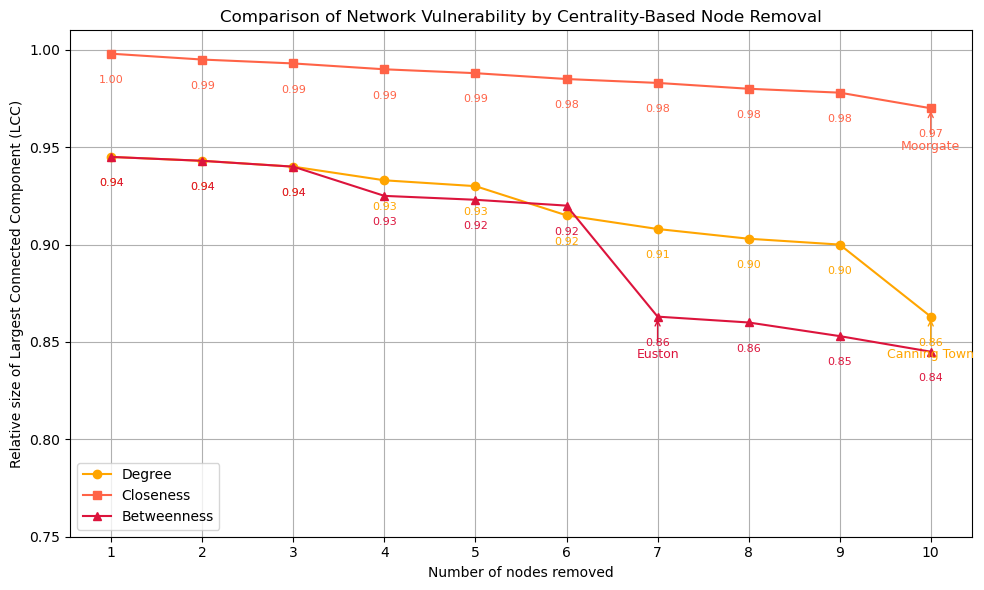

In [11]:
def compare_node_removal_highlight_worst(G, centrality_list, remove_n=10):

    original_node_count = G.number_of_nodes()
    colors = {'degree': 'orange', 'closeness': 'tomato', 'betweenness': 'crimson'}
    markers = {'degree': 'o', 'closeness': 's', 'betweenness': '^'}

    plt.figure(figsize=(10, 6))

    for centrality_name in centrality_list:
        G_temp = G.copy()
        nodes_sorted = sorted(
            G_temp.nodes(data=True),
            key=lambda x: x[1][centrality_name],
            reverse=True
        )

        lcc_sizes = []
        removed_names = []

        for i in range(remove_n):
            node_to_remove = nodes_sorted[i][0]
            removed_names.append(node_to_remove)
            G_temp.remove_node(node_to_remove)

            if len(G_temp) > 0:
                lcc = max(nx.connected_components(G_temp), key=len)
                lcc_size = len(lcc) / original_node_count
            else:
                lcc_size = 0

            lcc_sizes.append(round(lcc_size, 3))

        x_vals = list(range(1, remove_n + 1))
        plt.plot(x_vals, lcc_sizes,
                 label=centrality_name.capitalize(),
                 color=colors[centrality_name],
                 marker=markers[centrality_name])

        # Annotate every point with LCC value
        for x, y in zip(x_vals, lcc_sizes):
            plt.text(x, y - 0.015, f"{y:.2f}", ha='center', fontsize=8, color=colors[centrality_name])


        # Find largest drop
        drops = [lcc_sizes[i - 1] - lcc_sizes[i] for i in range(1, remove_n)]
        max_drop_idx = drops.index(max(drops)) + 1  # index in lcc_sizes
        max_station = removed_names[max_drop_idx]

        # Annotate station name at biggest drop
        plt.annotate(
            f"{max_station}",
            (x_vals[max_drop_idx], lcc_sizes[max_drop_idx]),
            textcoords="offset points",
            xytext=(0, -30),
            ha='center',
            fontsize=9,
            color=colors[centrality_name],  # Set annotation text color
            arrowprops=dict(arrowstyle="->", color=colors[centrality_name])
        )

    plt.xlabel("Number of nodes removed")
    plt.ylabel("Relative size of Largest Connected Component (LCC)")
    plt.title("Comparison of Network Vulnerability by Centrality-Based Node Removal")
    plt.ylim(0.75, 1.01)
    plt.xticks(range(1, remove_n + 1))
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()


compare_node_removal_highlight_worst(G, ['degree', 'closeness', 'betweenness'], remove_n=10)

### 2. Flows: weighted network

In [12]:
definition_df = pd.read_excel('code_data/code_data/NUMBAT/NBT19_Definitions.xlsx', 'Stations')

#we will drop any missing values from our dataframe
definition_df.dropna(inplace=True)

#transform mnlc codes from floats to int
definition_df.MNLC = definition_df.MNLC.astype(int)
definition_df.head()

MNLC  MASC                  StationName  TFL?
0   500  ACTu                   Acton Town  True
1   501  BARu                     Barbican  True
2   502  ALDu                      Aldgate  True
3   503  ALEu                 Aldgate East  True
4   504  STId  Stratford International DLR  True

In [13]:
#tlf provides passenger flow data for each network separately
#we need to create a list of all the different files we need
files = ['NBT19MTT2b_od__DLR_tb_wf.csv', 
         'NBT19MTT2b_od__EZL_tb_wf.csv', 
         'NBT19MTT2b_od__LO_tb_wf.csv', 
         'NBT19MTT2b_od__LU_tb_wf.csv']

#create an empty list to store dataframes for each file
dfs = []

#iterate through our files list, read the file and append to our dataframe list
for file in files:
    dfs.append(pd.read_csv('code_data/code_data/NUMBAT/' + file))
    
#merge all dataframes
london_OD = pd.concat(dfs, ignore_index=True)

In [14]:
london_OD.head()

mode_mnlc_o  mode_mnlc_d       2        3        4        5        6  \
0          504          523   8.033   16.430   24.563   28.555   13.023   
1          504          533  30.719   40.105   61.571   57.881   15.573   
2          504          538   5.941   17.238   37.493   43.158   33.890   
3          504          559   5.795   26.397   27.285   24.065   15.213   
4          504          573  77.786  113.750  143.938  387.562  165.776   

        7 mode   1   8  
0   2.263  DLR NaN NaN  
1   0.317  DLR NaN NaN  
2  10.429  DLR NaN NaN  
3   8.508  DLR NaN NaN  
4  65.283  DLR NaN NaN

In [15]:
#add the station names
london_OD['station_origin'] = london_OD['mode_mnlc_o'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD['station_destination'] = london_OD['mode_mnlc_d'].apply(lambda x: definition_df[definition_df.MNLC==x]['StationName'].values[0])
london_OD.head()

mode_mnlc_o  mode_mnlc_d       2        3        4        5        6  \
0          504          523   8.033   16.430   24.563   28.555   13.023   
1          504          533  30.719   40.105   61.571   57.881   15.573   
2          504          538   5.941   17.238   37.493   43.158   33.890   
3          504          559   5.795   26.397   27.285   24.065   15.213   
4          504          573  77.786  113.750  143.938  387.562  165.776   

        7 mode   1   8               station_origin  station_destination  
0   2.263  DLR NaN NaN  Stratford International DLR        King George V  
1   0.317  DLR NaN NaN  Stratford International DLR  London City Airport  
2  10.429  DLR NaN NaN  Stratford International DLR         Pontoon Dock  
3   8.508  DLR NaN NaN  Stratford International DLR      West Silvertown  
4  65.283  DLR NaN NaN  Stratford International DLR     Woolwich Arsenal

In [16]:
# we will only keep passenger flows for the timeband we are interested in
london_OD_AMpeak = london_OD[['station_origin', 'station_destination', '3']].copy()
#rename column
london_OD_AMpeak.rename({'3':'flows'}, axis=1, inplace=True)

#since the flows are averages the are stored as flows.
#for our analysis we will turn the into ints
london_OD_AMpeak.flows = london_OD_AMpeak.flows.astype(int)
london_OD_AMpeak.head()

station_origin  station_destination  flows
0  Stratford International DLR        King George V     16
1  Stratford International DLR  London City Airport     40
2  Stratford International DLR         Pontoon Dock     17
3  Stratford International DLR      West Silvertown     26
4  Stratford International DLR     Woolwich Arsenal    113

In [17]:
station_origin = list(london_OD_AMpeak.station_origin.values)
station_destination = list(london_OD_AMpeak.station_destination.values)
all_stations = list(set(station_origin + station_destination))
all_stations = sorted(all_stations, key=str.lower)

In [18]:
#check the duplicative station names
pattern = r'.*(?:LU|LO|NR|TfL|DLR|\(.*\)).*'
matches = [station for station in all_stations if re.search(pattern, station)]
#print duplicative station names
print('Duplicative station names:')
for station in sorted(matches): print(f'- {station}')

Duplicative station names:
- Balham LU
- Bethnal Green LO
- Bethnal Green LU
- Blackfriars LU
- Brixton LU
- Canary Wharf DLR
- Canary Wharf LU
- Cannon Street LU
- Charing Cross LU
- Edgware Road (Bak)
- Edgware Road (DIS)
- Elephant & Castle LU
- Euston LU
- Euston NR
- Finsbury Park LU
- Hammersmith (DIS)
- Hammersmith (H&C)
- Heathrow Terminal 4 LU
- Heathrow Terminal 5 LU
- Heathrow Terminals 123 LU
- Kensington (Olympia)
- Lewisham DLR
- Limehouse DLR
- Liverpool Street LU
- Liverpool Street NR
- London Bridge LU
- Marylebone LU
- Paddington NR
- Paddington TfL
- Shadwell DLR
- Shadwell LO
- Shepherd's Bush LU
- Shepherd's Bush NR
- Stratford International DLR
- Tottenham Hale LU
- Vauxhall LU
- Victoria LU
- Waterloo LU
- West Croydon NR
- West Hampstead LO
- West Hampstead LU


In [19]:
london_OD_AMpeak['station_origin'] = london_OD_AMpeak.station_origin.apply(lambda x: 
    re.sub(r'\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
)

london_OD_AMpeak['station_destination'] = london_OD_AMpeak.station_destination.apply(lambda x: 
    re.sub(r'\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', x)
)

#group by origin and destination station and sum the flows
london_OD_AMpeak = london_OD_AMpeak.groupby(['station_origin', 'station_destination'], as_index=False).sum()

london_OD_AMpeak

station_origin station_destination  flows
0            Abbey Road   Bank and Monument      0
1            Abbey Road             Beckton      1
2            Abbey Road           Blackwall      3
3            Abbey Road        Canary Wharf      1
4            Abbey Road        Canning Town     37
...                 ...                 ...    ...
61523  Woolwich Arsenal       Tower Gateway    127
61524  Woolwich Arsenal            West Ham    608
61525  Woolwich Arsenal     West India Quay      6
61526  Woolwich Arsenal     West Silvertown     81
61527  Woolwich Arsenal           Westferry     76

[61528 rows x 3 columns]

In [20]:
#let's sanity check and see the highest and lowest flows in and out flows
outflows = london_OD_AMpeak.groupby('station_origin', as_index=False).sum()

outflows.sort_values('flows',ascending=False).head(5)

station_origin                                station_destination  \
371          Waterloo  Acton TownAldgateAldgate EastAlpertonAmershamA...   
333         Stratford  Abbey RoadActon CentralActon TownAldgateAldgat...   
362          Victoria  Acton TownAldgateAldgate EastAlpertonAmershamA...   
219     London Bridge  Acton TownAldgateAldgate EastAlpertonAmershamA...   
218  Liverpool Street  Acton TownAldgateAldgate EastAlpertonAmershamA...   

     flows  
371  67372  
333  59311  
362  37517  
219  32597  
218  31473

In [21]:
#let's sanity check and see the highest and lowest flows in and out flows
inflows = london_OD_AMpeak.groupby('station_destination', as_index=False).sum()
inflows.sort_values('flows',ascending=False).head(5)

station_destination                                     station_origin  \
16    Bank and Monument  Abbey RoadActon TownAldgateAldgate EastAll Sai...   
218    Liverpool Street  Acton TownAldgateAldgate EastAlpertonAmershamA...   
56         Canary Wharf  Abbey RoadActon TownAldgateAldgate EastAll Sai...   
333           Stratford  Abbey RoadActon CentralActon TownAldgateAldgat...   
257       Oxford Circus  Acton TownAldgateAldgate EastAlpertonAmershamA...   

     flows  
16   78549  
218  61122  
56   58772  
333  55954  
257  44368

In [22]:
#read in the data using geopandas
stations = gpd.read_file('code_data/code_data/NUMBAT/tfl_stations.json')
lines = gpd.read_file('code_data/code_data/NUMBAT/tfl_lines.json')

stations = stations.to_crs(epsg = 27700)
lines = lines.to_crs(epsg = 27700)

In [23]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [24]:
#get all station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}

In [25]:
#clean station names
for k, v in station_names.items():
    if k == 'none':
        continue
    #cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    cleaned_name = re.sub(r'\sLU\s?|\sLO\s?|\sNR\s?|\sTf[L1]\s?|\sDLR\s?|\s\(.*\)', '', v)

    
    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])

In [26]:
#get position of stations as mean of x, y of stations

#create empty dict to store list of coordinates
pos = {}

#iterate through the stations
for i, station in stations.iterrows():
    xy = station.geometry.coords[0]
    
    #if station already in dict add coordinate to coordinate list
    if station['name'] in pos.keys():
        pos[station['name']].extend([xy])
    #if station is not in the dict add station to dict and set first coordinate in list
    else:
        pos[station['name']] = [xy]

#iterate through our dict and replace coordinate list with mean value
for k, v in pos.items():
    #we set axis to 0 to make sure to take mean of x and y coordinates
    pos[k] = np.mean(v, axis=0)

In [27]:
#set new geometry
stations['geometry'] = stations['name'].apply(lambda x: Point(pos[x]))

<Axes: >

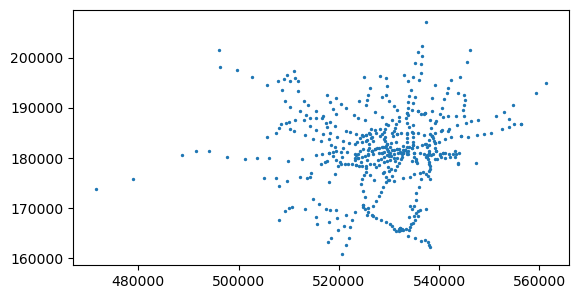

In [28]:
#check plot to make sure there are no errors
stations.plot(markersize=2)

In [29]:
lines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        701 non-null    object  
 1   lines     701 non-null    object  
 2   geometry  701 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 16.6+ KB


In [30]:
#get all line types as a list and subset geoms by lines
line_names  = lines.lines.apply(lambda x: [x['name'] for x in json.loads(x)] )
line_names = list(set([item for sublist in line_names for item in sublist]))
line_names

['East London',
 'District',
 'Bakerloo',
 'Victoria',
 'Northern',
 'TfL Rail',
 'DLR',
 'Crossrail 2',
 'Metropolitan',
 'Circle',
 'Waterloo & City',
 'Crossrail',
 'Emirates Air Line',
 'Jubilee',
 'Central',
 'Tramlink',
 'London Overground',
 'Hammersmith & City',
 'Piccadilly',
 'Thameslink 6tph line']

In [31]:
#merge East London line and London Overground since they are one line
lines.lines = lines.lines.str.replace('East London', 'London Overground')
stations.lines = stations.lines.str.replace('East London', 'London Overground')

In [32]:
#exclude the lines that we are not going to use
excluded_lines = ['Thameslink 6tph line', 'East London', 'Crossrail 2', 'Emirates Air Line', 'Crossrail', 'Tramlink']

District


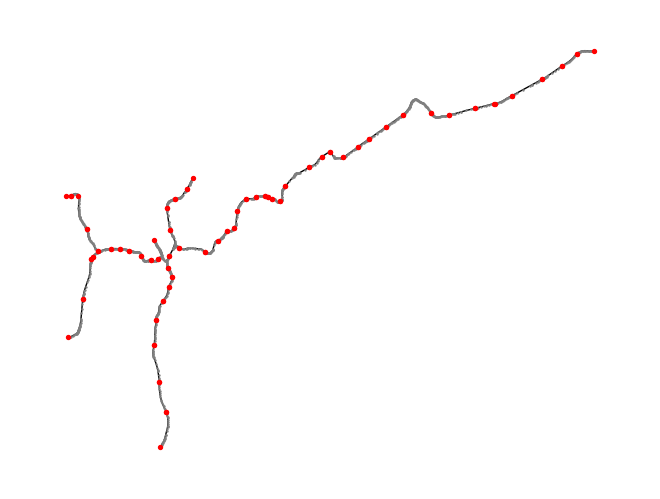

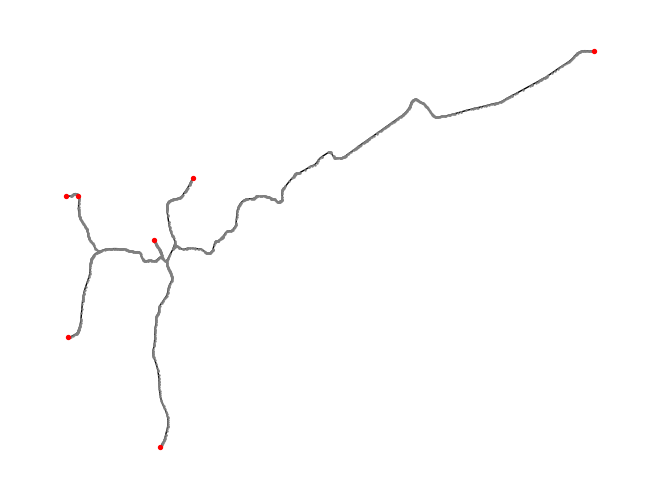

1
Bakerloo


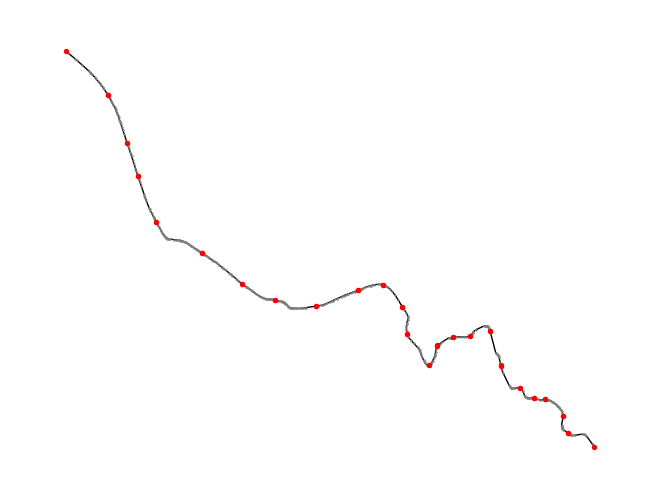

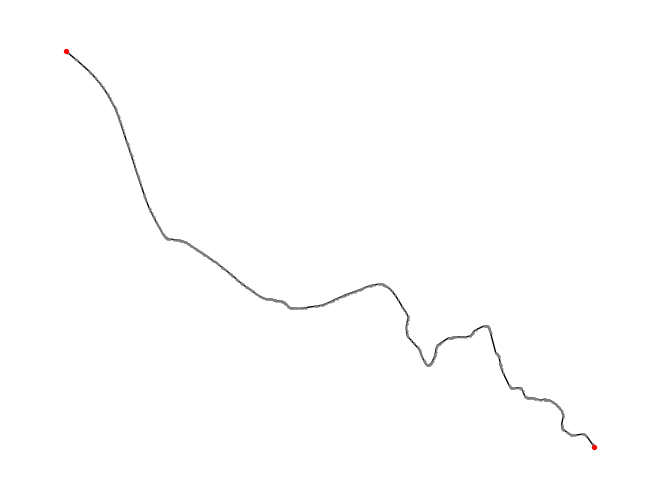

1
Victoria


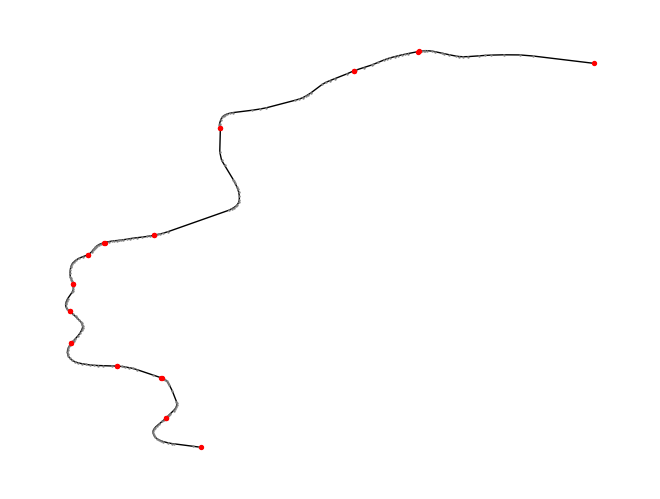

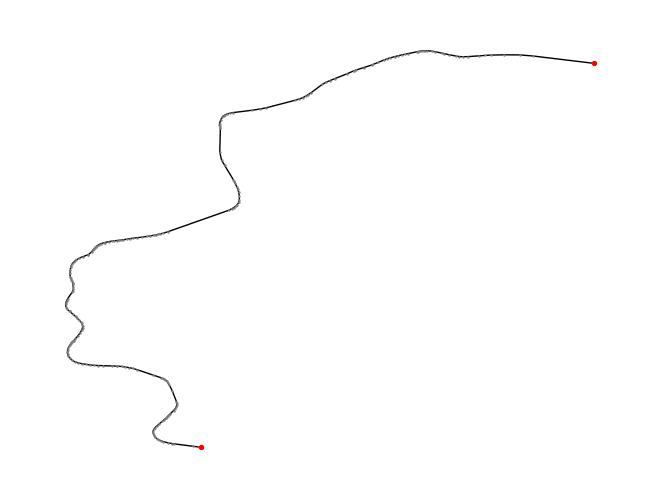

1
Northern


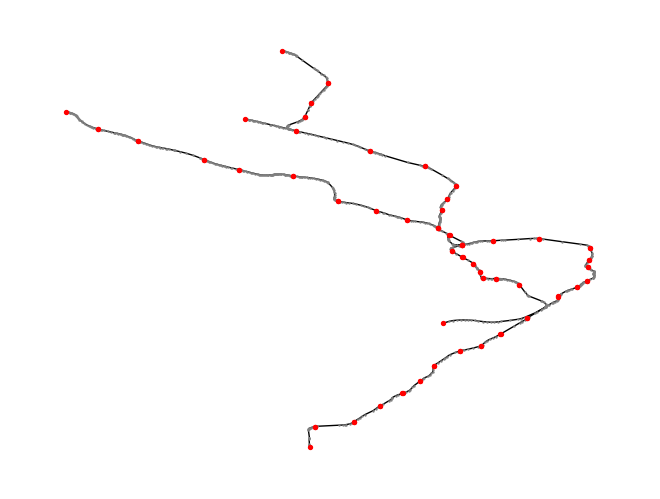

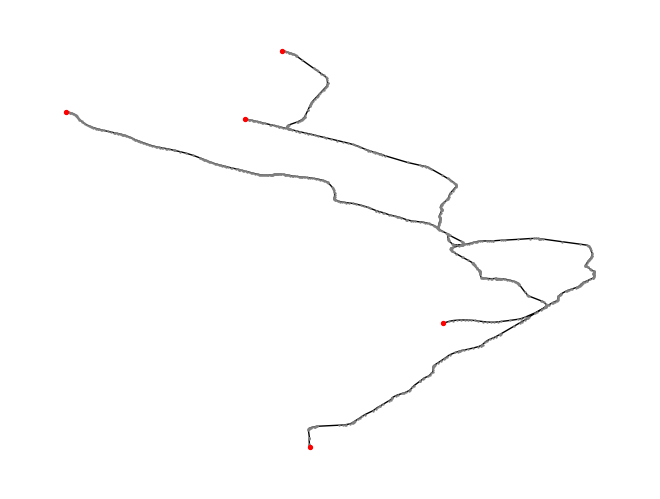

1
TfL Rail


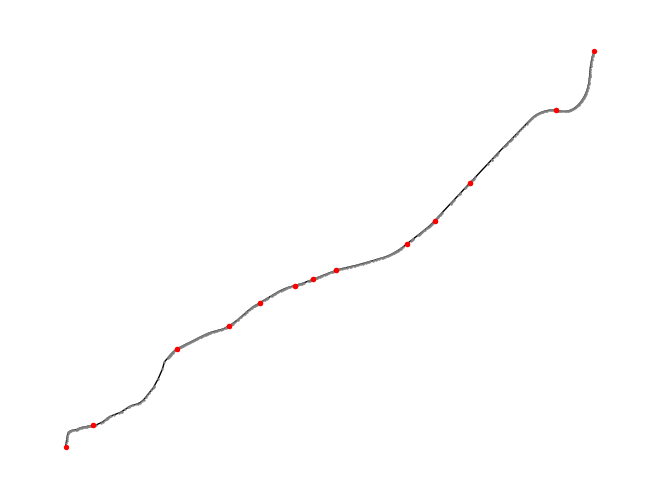

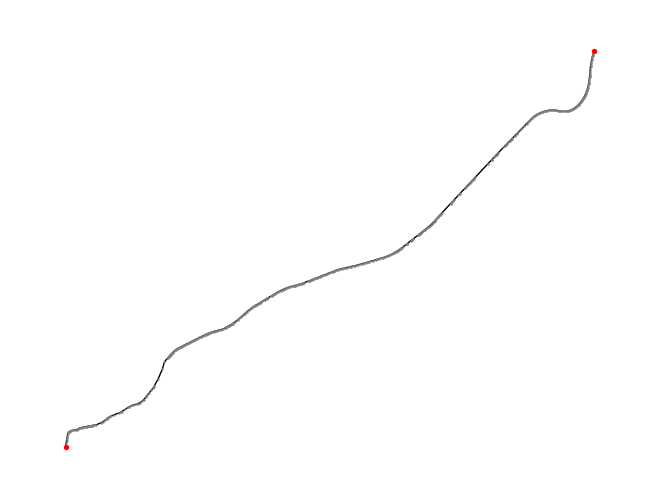

1
DLR


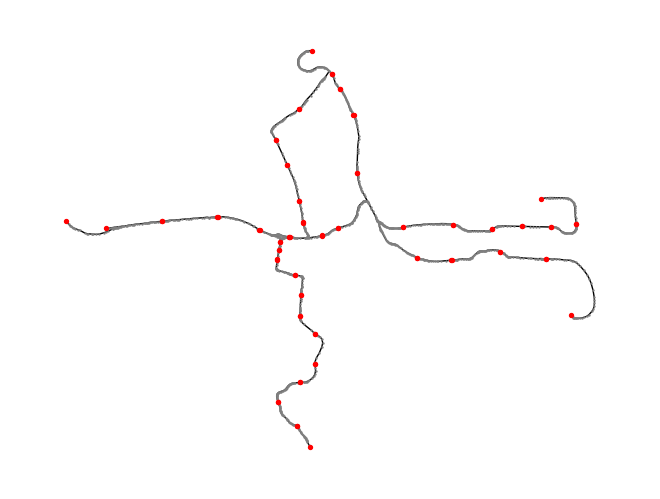

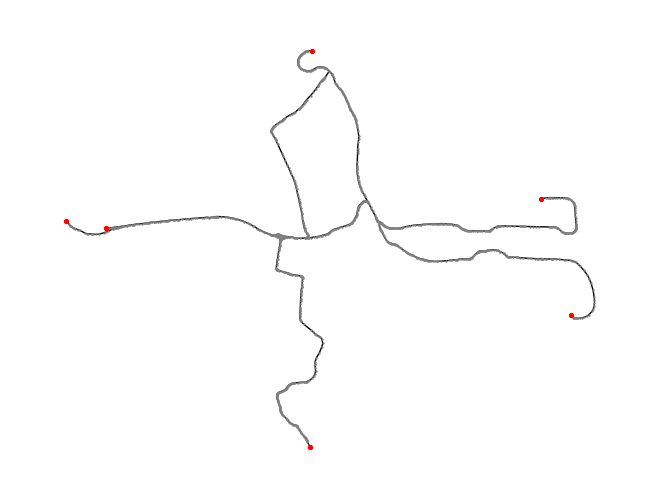

1
Metropolitan


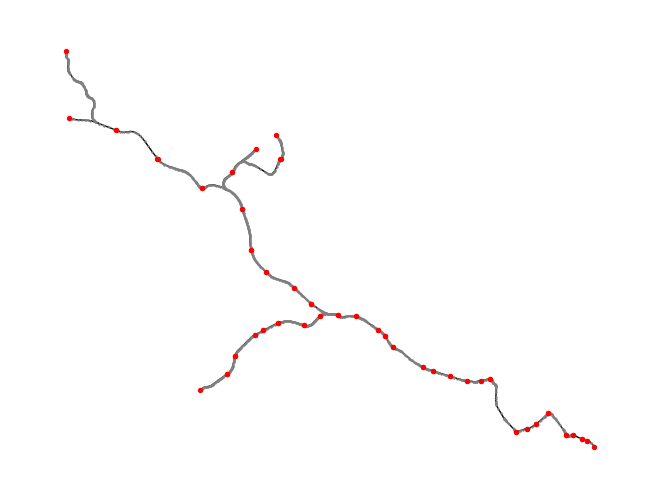

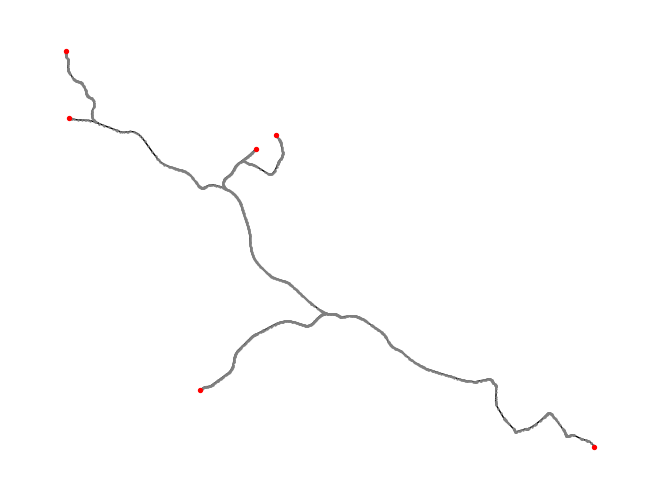

1
Circle


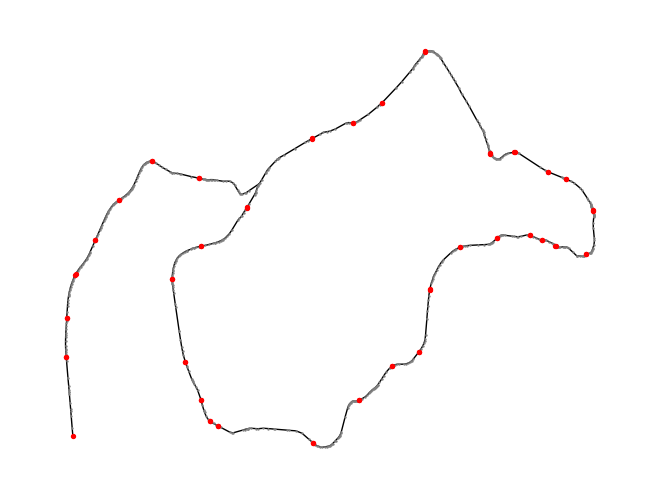

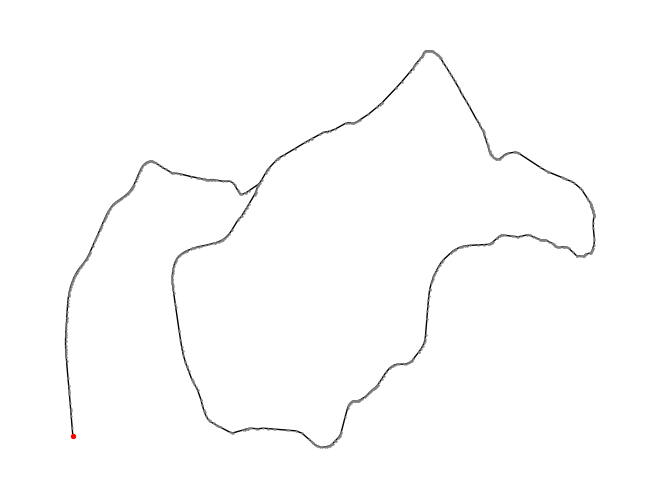

1
Waterloo & City


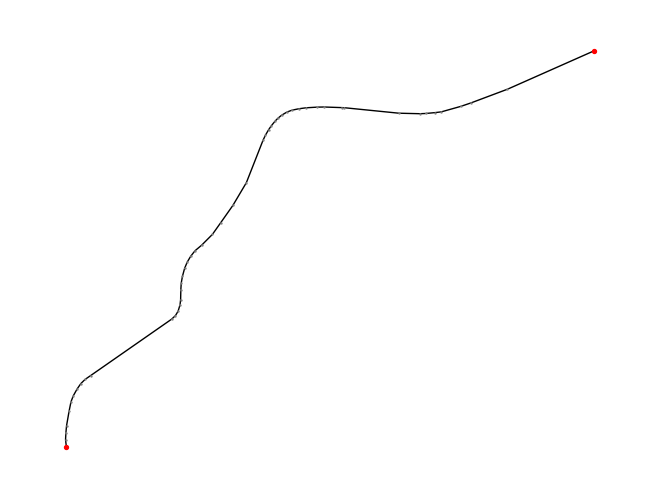

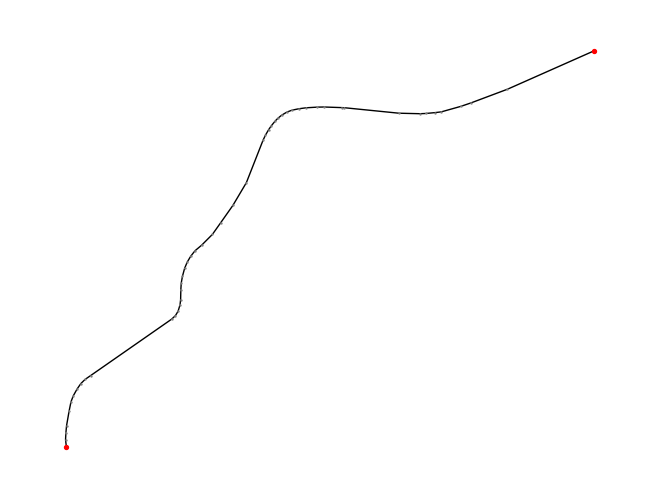

1
Jubilee


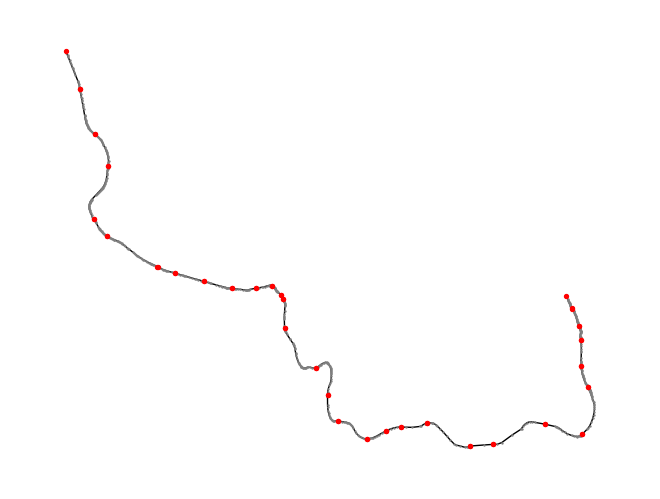

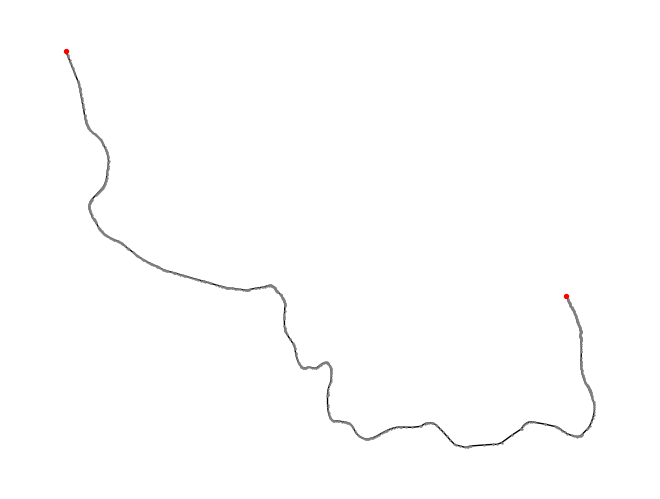

1
Central


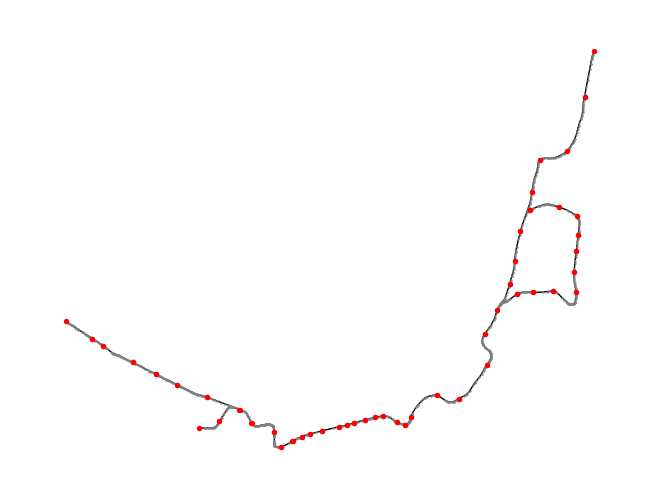

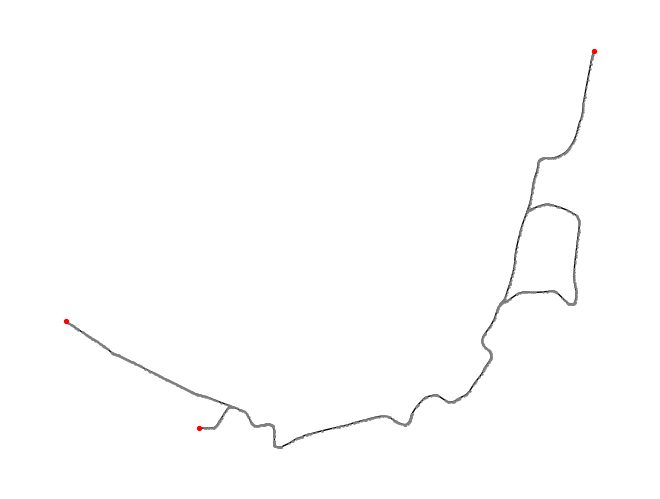

1
London Overground


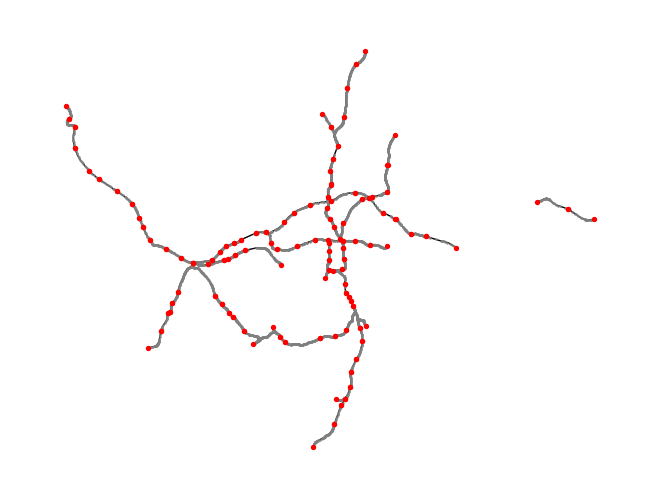

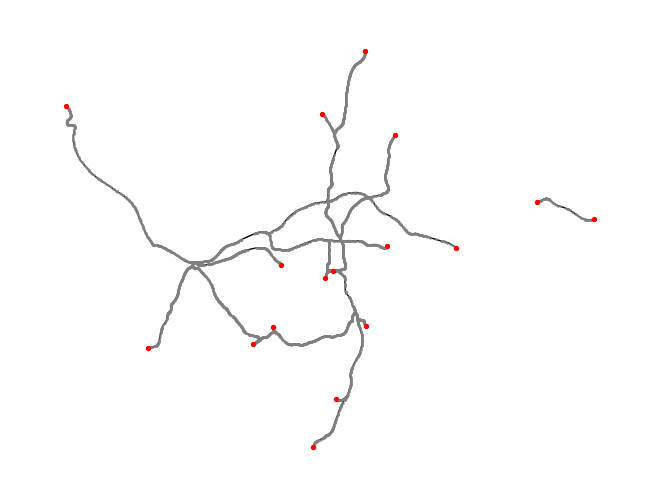

3
Hammersmith & City


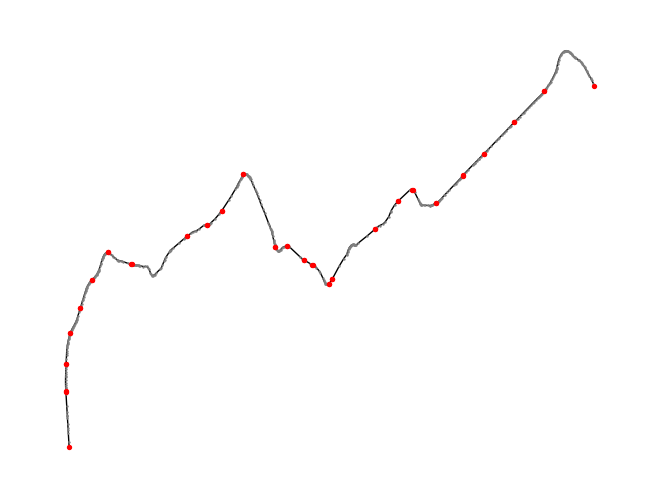

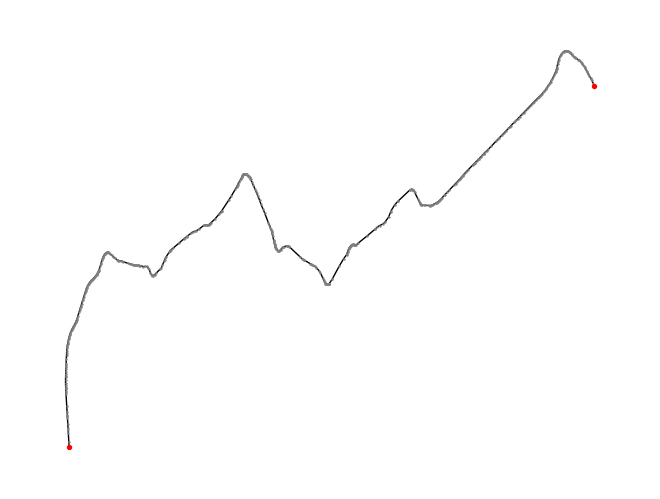

1
Piccadilly


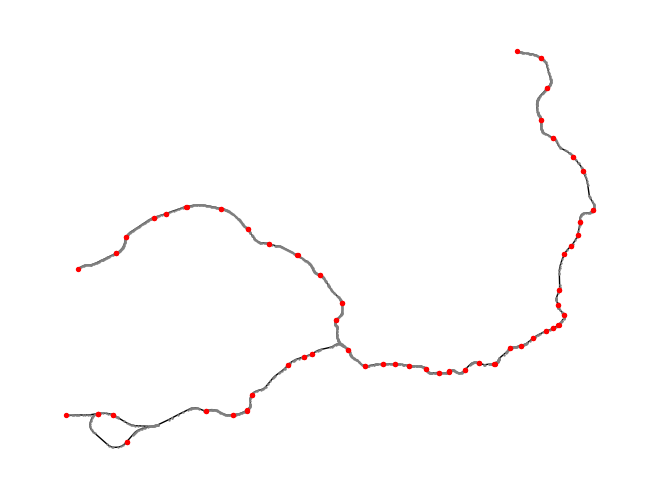

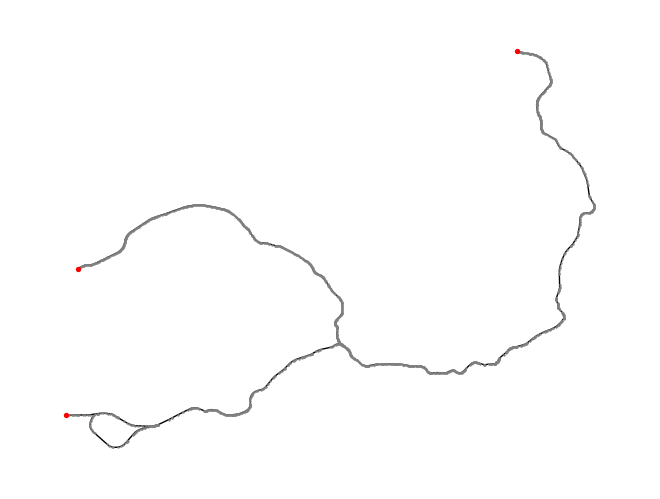

1


In [33]:
#create an empty dict to hold our geometric graphs
geometric_graphs = {}

#iterate through each line individually
for line_name in line_names:
    #skip lines that we won't be using
    if line_name in excluded_lines :
        continue
    print(line_name)
    
    #subset our line and station files for the ones the belong to a specific line
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #create empty graph
    G= nx.Graph()
    
    #iterate through our line geometries
    for i, line in temp_lines.iterrows():
        #get list of coordinates that define our line
        _l = list(line.geometry.coords)

        #add coordinates as edges
        G.add_edges_from(list(zip(_l,_l[1:])))
    
    #remove any self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    #the position of the node is the name of the node
    #let's extract this to plot our graph
    pos = {n: n for n in G.nodes()}
    
    # get degree one nodes
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #let's plot our graph and all degree one nodes
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    
    #get distance between all points of 1-degree, this will be a matrix
    dist = distance.cdist(k1, k1)
    
    #add edges between points that are close
    for j in range(dist.shape[0]-1):
        temp = dist[j][j+1:]
        #get index of closest node
        i_min = np.argmin(temp)
        if dist[j][i_min+j+1]<50:
            G.add_edge(k1[j],k1[i_min+j+1])
    
    #recalculate degree
    D = nx.degree(G)
    k1 = [node for node,degree in D if degree==1]
    #plot new graph
    nx.draw(G, pos=pos, node_size=0.5, node_color='grey')
    nx.draw_networkx_nodes(G, pos=pos, nodelist=k1, node_color='red', node_size=8)
    plt.show()
    print(nx.number_connected_components(G))
    #store graph in dictionary
    geometric_graphs[line_name] = G


In [34]:
#create a dataframe with all geometries from all valid lines
#this list will contain a dictionary for each edge in our graph that contains
# node pairs, line name, and a geometry (this is just for quick visualization purposes and will be replaced by true geometry)
edge_list = []
def _has_ids(k):
    #helper function to check if line contains id of start and end station
    if ('start_sid' in k.keys()) and ('end_sid' in k.keys()):
        return True
    else:
        return False

#iterate through each line seperately 
for line_name in line_names:
    if line_name in excluded_lines :
        continue
        
    #subset lines and stations
    temp_lines = lines[lines.lines.str.contains(line_name)]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #for each line in our subset dataframe get each origin and destination pair
    for i, line in temp_lines.iterrows():
        for k in json.loads(line.lines):
            if k['name'] == line_name:
                if _has_ids(k):
                    #get start and end station ids
                    start_id = k['start_sid']
                    end_id = k['end_sid']

                    #get info of start and end station
                    start_station = temp_stations[(temp_stations.id == start_id) | (temp_stations.altmodeid == start_id)].values
                    end_station = temp_stations[(temp_stations.id == end_id) | (temp_stations.altmodeid == end_id)].values
                    
                    #if no matching station exist, let's just take the starting and ending coordinate of the line for now
                    if len(start_station) >= 1 and len(end_station) >=1:
                        s_geom = start_station[0][-1].coords[0]
                        e_geom = end_station[0][-1].coords[0]
                        edge_list.append({
                            'line_name': line_name,
                            'start_id': start_id,
                            'end_id': end_id,
                            'geometry': LineString([s_geom, e_geom])
                        })

line_name     start_id       end_id  \
0  District  940GZZLUECT  940GZZLUGTR   
1  District  940GZZLUECT  940GZZLUWKN   
2  District  940GZZLUWKN  940GZZLUBSC   
3  District  940GZZLUBSC  940GZZLUHSD   
4  District  940GZZLUHSD  940GZZLURVP   

                                            geometry  
0  LINESTRING (525466.77 178494.187, 526201.148 1...  
1  LINESTRING (525466.77 178494.187, 524648.937 1...  
2  LINESTRING (524648.937 178386.727, 524110.791 ...  
3  LINESTRING (524110.791 178324.969, 523377.084 ...  
4  LINESTRING (523377.084 178624.185, 522569.788 ...

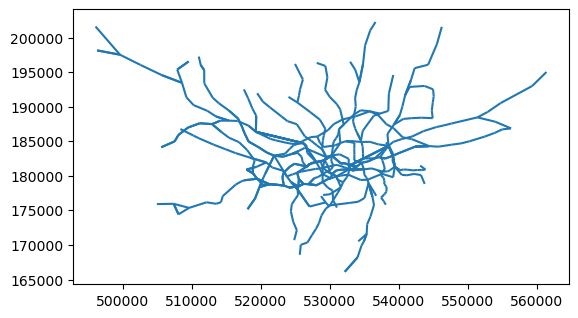

In [35]:
#turn our dictionary list into a geopandas df to quickly plot and sanity check our work
edge_gdf = gpd.GeoDataFrame(edge_list)
edge_gdf.crs = lines.crs
edge_gdf.plot()
edge_gdf.head()

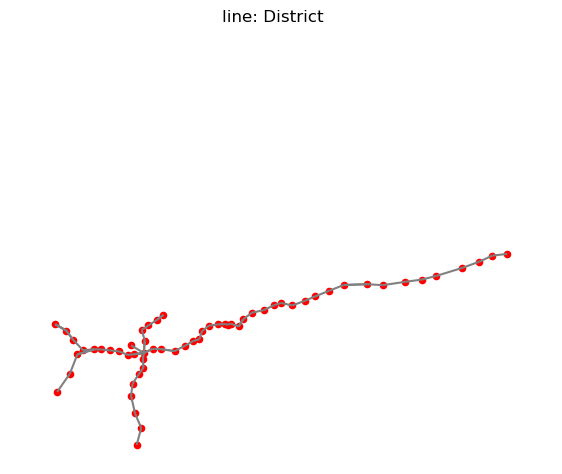

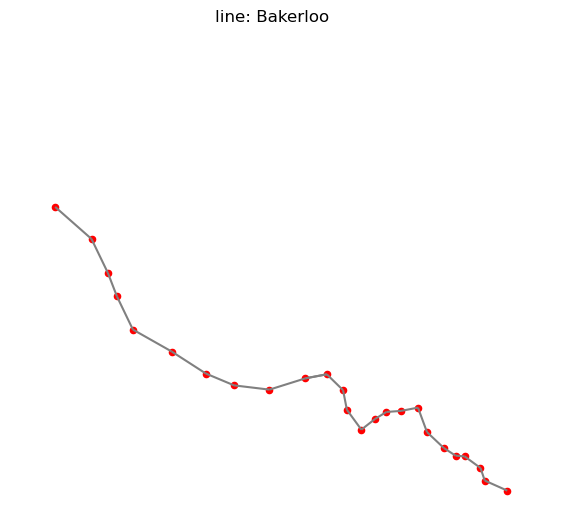

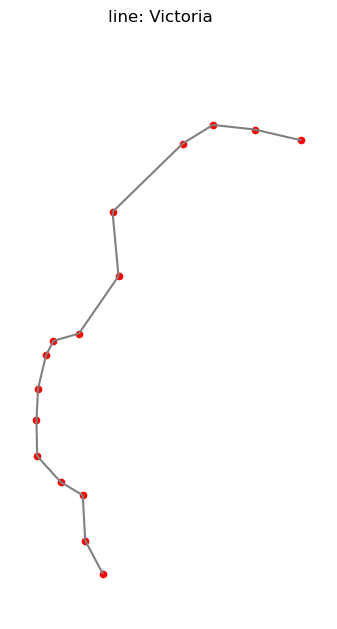

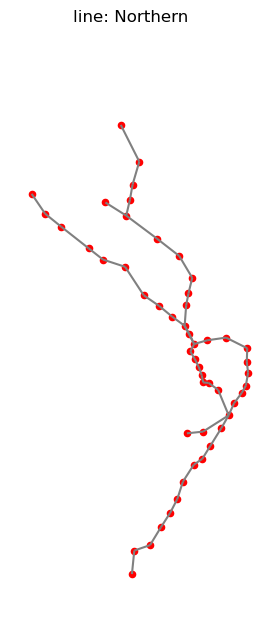

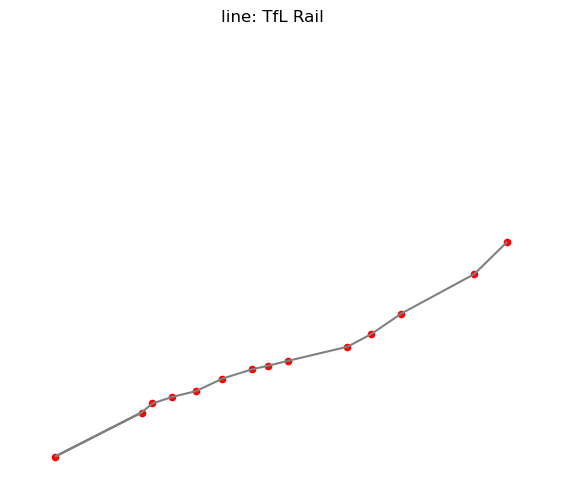

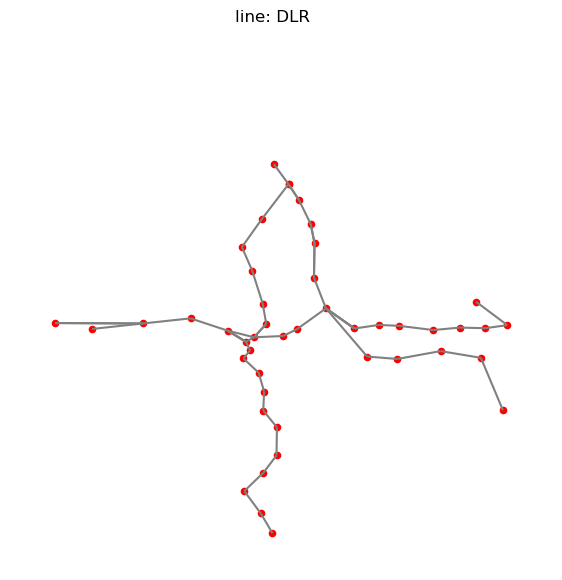

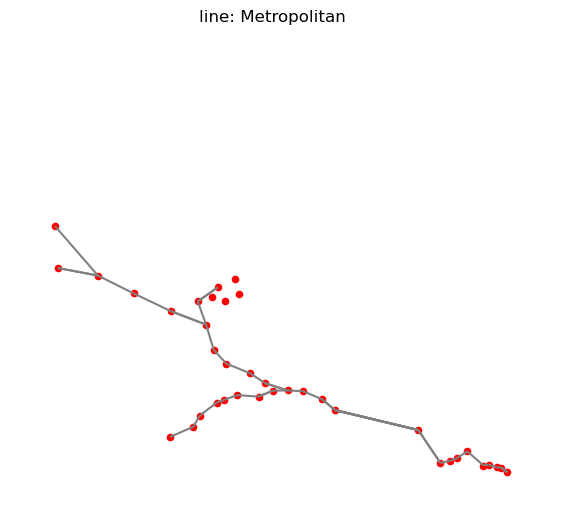

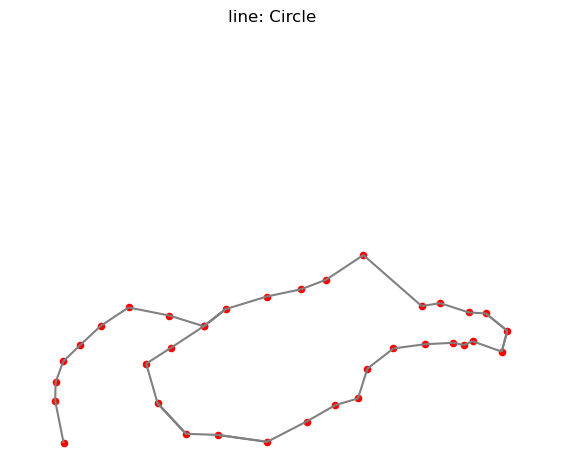

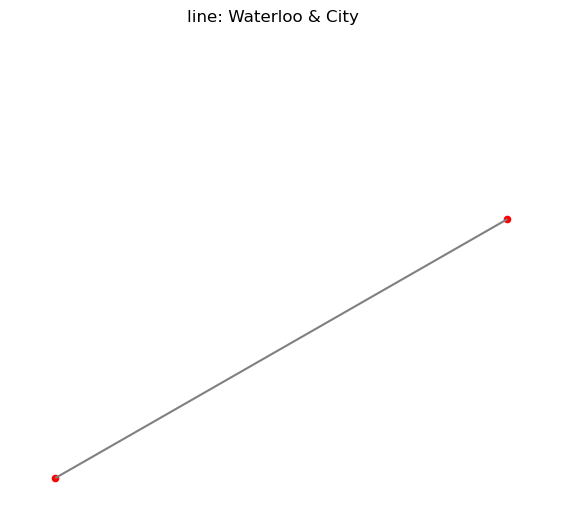

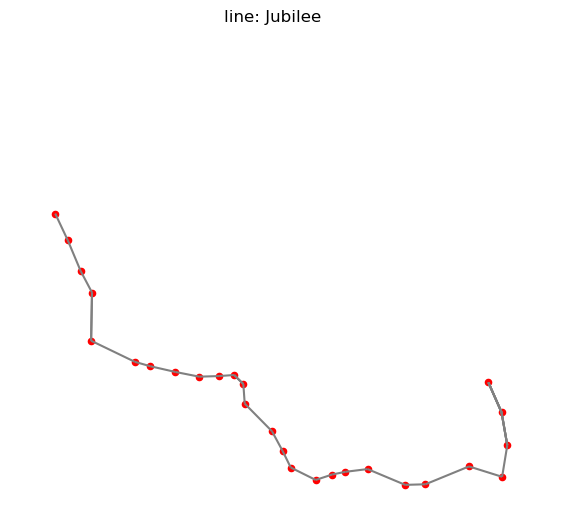

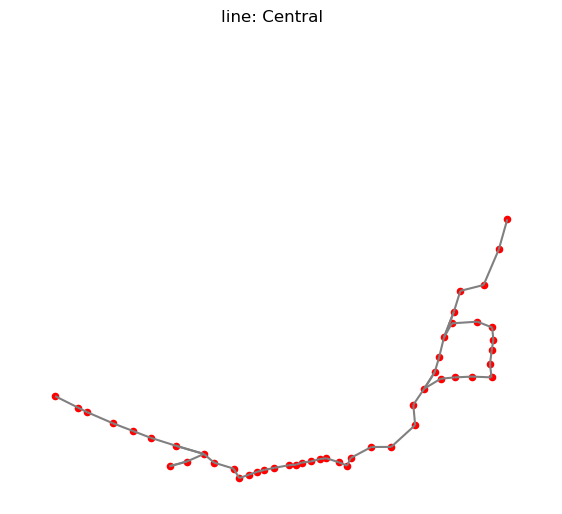

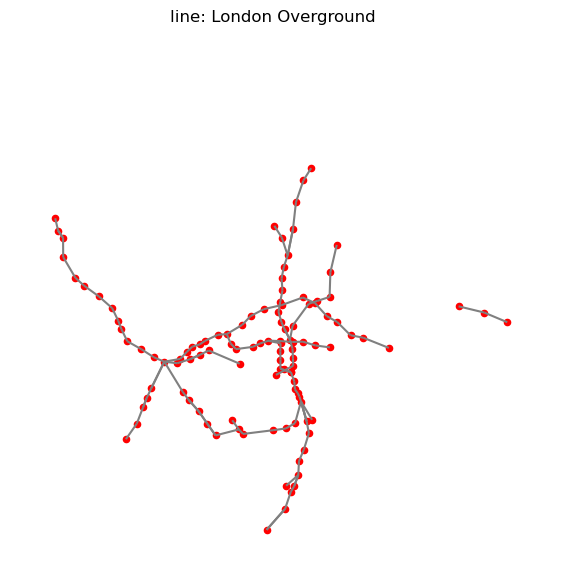

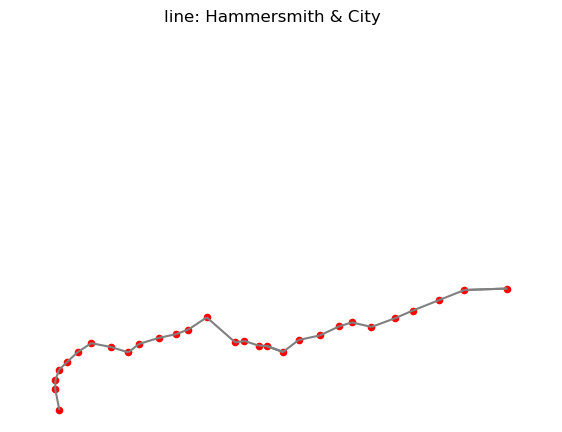

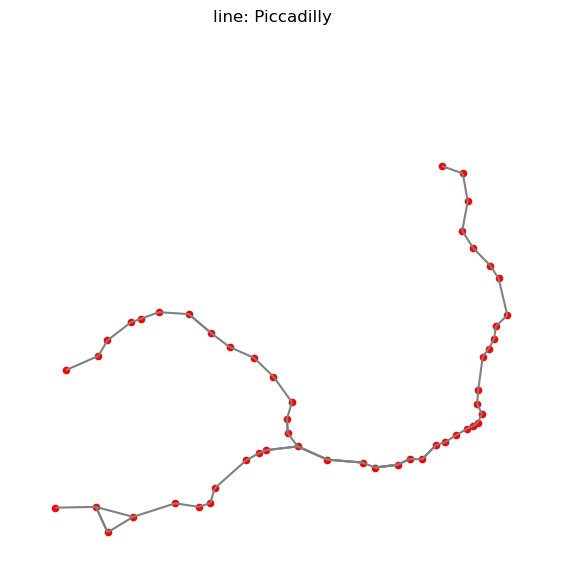

In [36]:
### Add geometry information back into the graph
for line_name in line_names:
    if line_name in excluded_lines :
        continue
    temp_lines = edge_gdf[edge_gdf.line_name == line_name]
    temp_stations = stations[stations.lines.str.contains(line_name)]
    
    #let's plot our lines so we can check them
    fig, ax = plt.subplots(figsize = (7,7))
    fig.suptitle(f'line: {line_name}')
    ax.set_aspect("equal")
    ax.axis('off')
    ax.margins(0.1)
    
    base = temp_lines.plot(ax=ax, color='grey')
    temp_stations.plot(ax=base, markersize=20, color='red')
    plt.show()
    
    #add real geometry back
    for i, edge in temp_lines.iterrows():
        #get start and end of line coordinates
        start = edge.geometry.coords[0]
        end = edge.geometry.coords[-1]
        
        #let's get all the coordinates in our geometric graph
        nodes = list(geometric_graphs[line_name].nodes)
        
        #find nearest node in graph to origin and destination
        s_dist = distance.cdist([start], nodes)[0]
        s_i = np.argmin(s_dist)
        source= nodes[s_i]
        
        t_dist = distance.cdist([end], nodes)[0]
        t_i = np.argmin(t_dist)
        target= nodes[t_i]
        
        #get shortest path
        sp = nx.shortest_path(geometric_graphs[line_name], source, target)
        
        #make into geometry
        #notice how I'm also adding the start and end coordinates to the line definition
        #this fixes the problem of stations and lines not matching up
        geometry = LineString([start] + sp + [end])
        edge_gdf.loc[i, 'geometry'] = geometry

<Axes: >

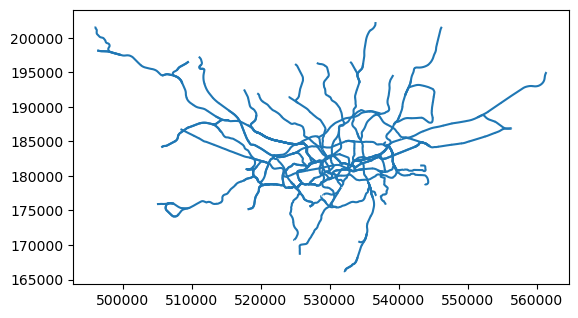

In [37]:
#plot to sanity check
edge_gdf.plot()

In [38]:
#let's store the length of the real geometry
edge_gdf['length'] = edge_gdf.geometry.length

In [39]:
#let's replace the ids with the actual name
#get all station names
station_names_2 = {row.altmodeid: row['name'] for i, row in stations.iterrows() if row.altmodeid != None}
station_names.update(station_names_2)

In [40]:
edge_gdf['start_id'] = edge_gdf['start_id'].apply(lambda x: station_names[x])
edge_gdf['end_id'] = edge_gdf['end_id'].apply(lambda x: station_names[x])

In [41]:
edge_gdf.head()

line_name         start_id            end_id  \
0  District     Earl's Court   Gloucester Road   
1  District     Earl's Court   West Kensington   
2  District  West Kensington      Barons Court   
3  District     Barons Court       Hammersmith   
4  District      Hammersmith  Ravenscourt Park   

                                            geometry      length  
0  LINESTRING (525466.77 178494.187, 525467.893 1...  910.121214  
1  LINESTRING (525466.77 178494.187, 525467.893 1...  944.065294  
2  LINESTRING (524648.937 178386.727, 524650.245 ...  563.676145  
3  LINESTRING (524110.791 178324.969, 524109.411 ...  893.832086  
4  LINESTRING (523377.084 178624.185, 523372.628 ...  840.102918

In [42]:
#now we can use this to create our network!
G = nx.from_pandas_edgelist(edge_gdf, source = 'start_id', target='end_id', edge_attr=['length', 'line_name'])

{'DLR', 'Northern', 'District', 'Bakerloo', 'Hammersmith & City', 'Victoria', 'Piccadilly', 'Metropolitan', 'Central', 'Circle', 'Waterloo & City', 'London Overground', 'TfL Rail', 'Jubilee'}


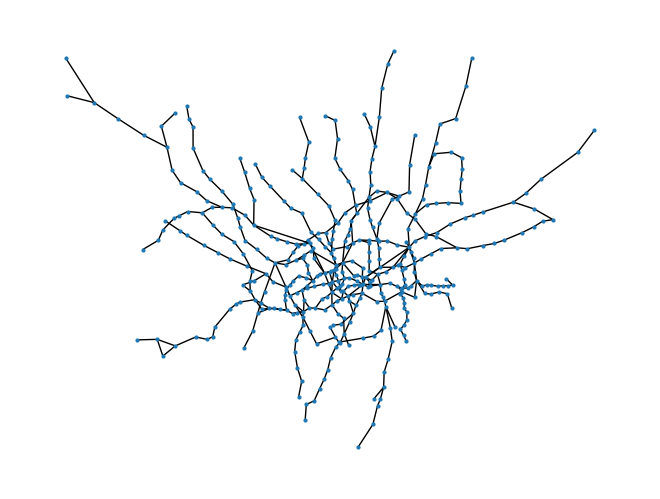

In [43]:
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

In [44]:
#save position to graph
nx.set_node_attributes(G, pos, 'coords')

In [45]:
#check that all distances are greater or equal to euclidean distance
for u,v, data in G.edges(data=True):
    assert(data['length'] >= distance.euclidean(pos[u], pos[v]))

In [46]:
#if want to know what is the maximum distance between stations
max(dict(G.edges).items(), key=lambda x: x[1]['length'])

(('Wembley Park', 'Finchley Road'),
 {'length': 7266.373927496685, 'line_name': 'Metropolitan'})

In [47]:
#check that our OD data and network data match
OD_names = set(london_OD_AMpeak.station_origin.unique())
network_names = set([n for n in G.nodes()])

In [48]:
network_names.symmetric_difference(OD_names)

{'Acton Main Line',
 'Battersea Power Station',
 'Hanwell',
 'Hayes & Harlington',
 'Heathrow Terminal 4 EL',
 'Heathrow Terminals 123',
 'Heathrow Terminals 2 & 3',
 'Heathrow Terminals 2 & 3 EL',
 'Nine Elms',
 'Southall',
 "Walthamstow Queen's Road",
 'Walthamstow Queens Road',
 'West Ealing'}

In [49]:
name_map = {
    'Heathrow Terminal 4 EL': 'Heathrow Terminal 4',
    'Heathrow Terminals 123': 'Heathrow Terminals 2 & 3',
    'Heathrow Terminals 2 & 3 EL': 'Heathrow Terminals 2 & 3',
    "Walthamstow Queen's Road": 'Walthamstow Queens Road'
}

In [50]:
london_OD_AMpeak.station_origin = london_OD_AMpeak.station_origin.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)
london_OD_AMpeak.station_destination = london_OD_AMpeak.station_destination.apply(
    lambda x: name_map[x] if x in name_map.keys() else x
)

In [51]:
#let's filter out the stations that we don't have in our network
OD_names = set(london_OD_AMpeak.station_origin.unique())
_filter = list(network_names.symmetric_difference(OD_names))
_filter

['Nine Elms',
 'West Ealing',
 'Southall',
 'Hanwell',
 'Battersea Power Station',
 'Acton Main Line',
 'Hayes & Harlington']

In [52]:
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_origin.isin(_filter)]
london_OD_AMpeak = london_OD_AMpeak[~london_OD_AMpeak.station_destination.isin(_filter)]

In [53]:
#create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

In [54]:
#calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination
    
    #get shortest path
    path = nx.dijkstra_path(G, source, target)
    
    #our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path,path[1:])) 
    
    #add flows to our dict
    for u,v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

In [55]:
#set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows')

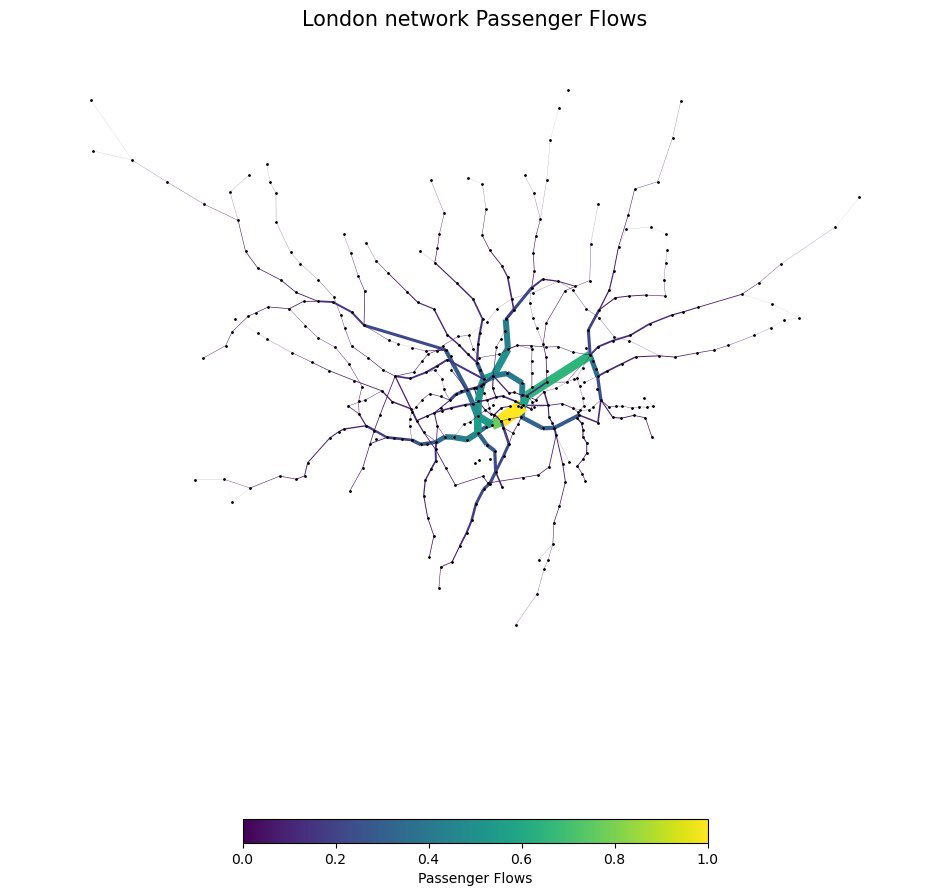

In [56]:
#plot our calcuated flows
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]

# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

#pos=nx.spring_layout(X)
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

In [57]:
#save graph
for i in G.nodes():
    G.nodes[i]['coords'] = str(G.nodes[i]['coords'])

#nx.write_graphml_lxml(G, "outputs/london_updated.graph")

In [58]:
#Degree 
deg = nx.degree_centrality(G)
nx.set_node_attributes(G, deg, 'degree')

#Closeness 
clo = nx.closeness_centrality(G, distance='length')
nx.set_node_attributes(G, clo, 'closeness')

#Betweenness 
for u, v, d in G.edges(data=True):
    if d['length'] > 0:
        d['inverted_length'] = 1 / d['length']
    else:
        d['inverted_length'] = 0  # fallback

# Compute betweenness centrality using inverted length
betweenness_centrality = nx.betweenness_centrality(G, weight='inverted_length', normalized=False)
nx.set_node_attributes(G, betweenness_centrality, 'betweenness')

In [59]:
data = []
for n, d in G.nodes(data=True):
    data.append({
        'station': n,
        'degree': d.get('degree', 0),
        'closeness': d.get('closeness', 0),
        'betweenness': d.get('betweenness', 0)
    })

df = pd.DataFrame(data)

# 输出各中心性 Top 5 排行
print("Top 5 by Degree Centrality:")
display(df.sort_values(by='degree', ascending=False).head(5))

print("Top 5 by Closeness Centrality:")
display(df.sort_values(by='closeness', ascending=False).head(5))

print("Top 5 by Betweenness Centrality:")
display(df.sort_values(by='betweenness', ascending=False).head(5))


Top 5 by Degree Centrality:


station  degree  closeness  betweenness
140                 Stratford  0.0225   0.000063      23670.0
38          Bank and Monument  0.0200   0.000077      23219.0
89   King's Cross St. Pancras  0.0175   0.000079      19197.0
74               Baker Street  0.0175   0.000076      15536.0
139          Liverpool Street  0.0150   0.000077      19237.0

Top 5 by Closeness Centrality:


station  degree  closeness  betweenness
264                   Holborn  0.0100   0.000079        658.0
89   King's Cross St. Pancras  0.0175   0.000079      19197.0
135      Tottenham Court Road  0.0100   0.000079        829.0
76              Oxford Circus  0.0150   0.000079       4253.0
136          Leicester Square  0.0100   0.000078          5.0

Top 5 by Betweenness Centrality:


station  degree  closeness  betweenness
140                 Stratford  0.0225   0.000063      23670.0
38          Bank and Monument  0.0200   0.000077      23219.0
79                   Waterloo  0.0150   0.000077      19884.0
139          Liverpool Street  0.0150   0.000077      19237.0
89   King's Cross St. Pancras  0.0175   0.000079      19197.0

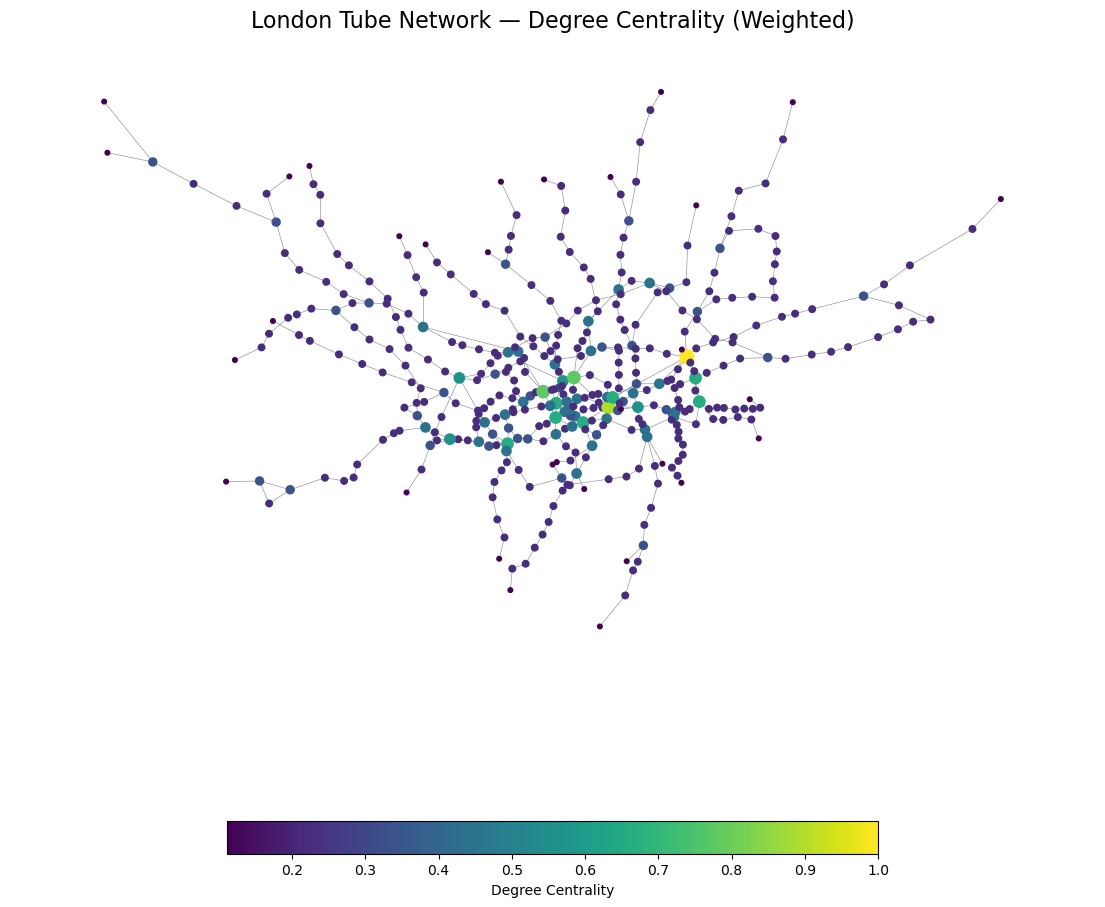

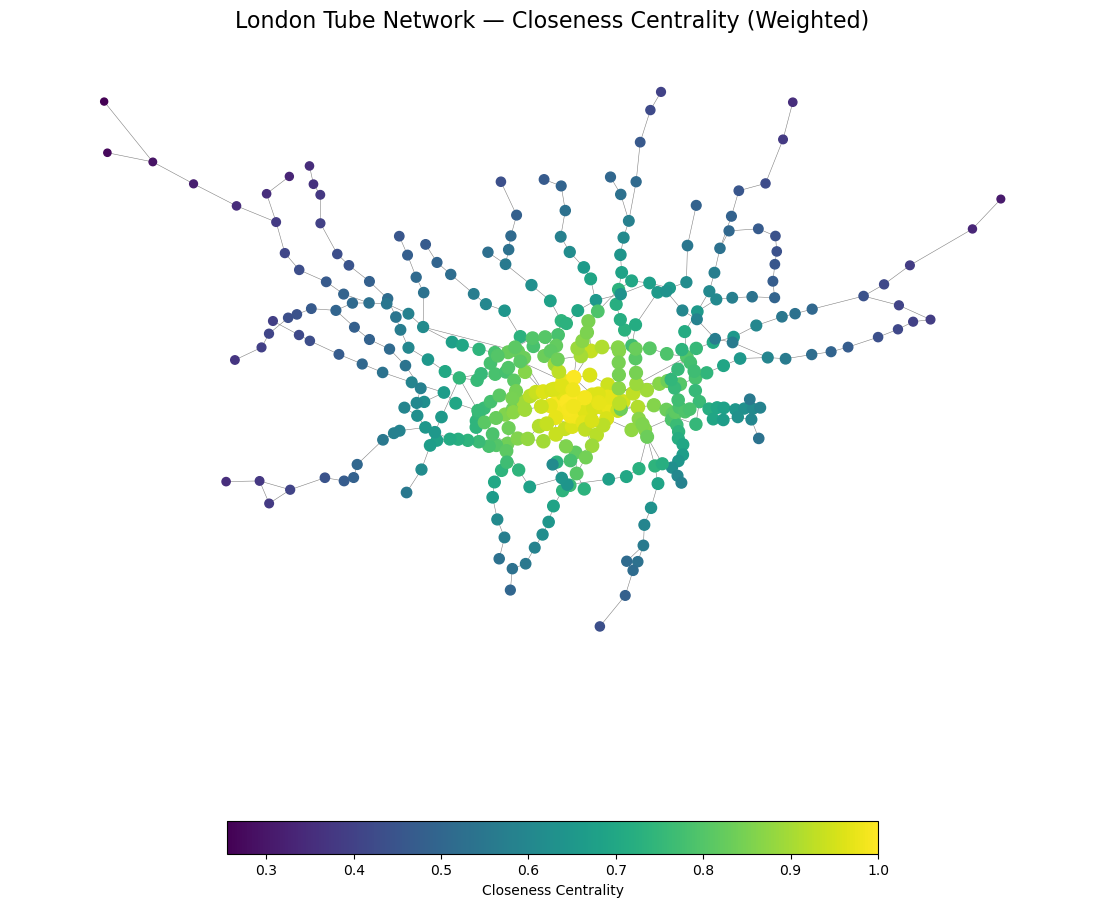

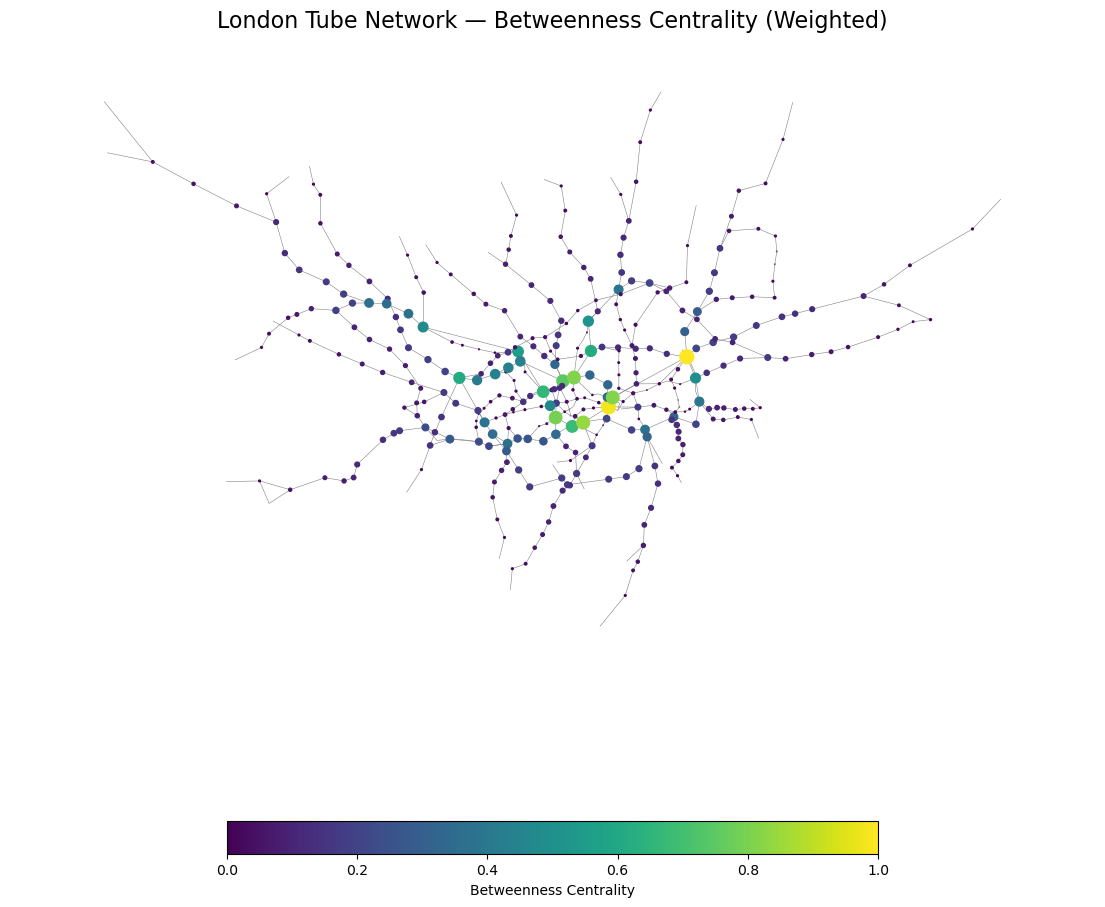

In [60]:
import ast

for n, data in G.nodes(data=True):
    if isinstance(data.get('coords'), str):
        try:
            G.nodes[n]['coords'] = ast.literal_eval(data['coords'])
        except:
            G.nodes[n]['coords'] = (0, 0)

pos = nx.get_node_attributes(G, 'coords') 


def plot_weighted_centrality(G, pos, centrality_name, scale=100, cmap='viridis'):
    """
    绘制加权网络的中心性图，自动排除没有坐标的节点。
    """
    # 过滤掉没有坐标的节点
    valid_nodes = [n for n in G.nodes if n in pos]
    values = [G.nodes[n].get(centrality_name, 0) for n in valid_nodes]

    max_val = max(values) if max(values) > 0 else 1
    norm_values = [v / max_val for v in values]
    sizes = [v * scale for v in norm_values]

    fig, ax = plt.subplots(figsize=(14, 12))

    # 只绘制有坐标的边
    valid_edges = [(u, v) for u, v in G.edges() if u in pos and v in pos]
    nx.draw_networkx_edges(G, pos, edgelist=valid_edges, edge_color='gray', width=0.4)

    nodes = nx.draw_networkx_nodes(
        G.subgraph(valid_nodes), pos,
        node_color=norm_values,
        node_size=sizes,
        cmap=cmap
    )

    plt.colorbar(nodes, label=f"{centrality_name.capitalize()} Centrality", orientation="horizontal", shrink=0.6)
    plt.title(f"London Tube Network — {centrality_name.capitalize()} Centrality (Weighted)", fontsize=16)
    plt.axis("off")
    plt.show()

plot_weighted_centrality(G, pos, 'degree')
plot_weighted_centrality(G, pos, 'closeness')
plot_weighted_centrality(G, pos, 'betweenness')


In [61]:
# Sort flows by value (descending) and get top 5
top_5_flows = sorted(flows.items(), key=lambda x: x[1], reverse=True)[:5]

# Convert to DataFrame
top_5_df = pd.DataFrame([
    {'Origin': origin, 'Destination': destination, 'Passenger Flow': flow}
    for (origin, destination), flow in top_5_flows
])

display(top_5_df)

Origin               Destination  Passenger Flow
0  Bank and Monument                  Waterloo          252173
1        Westminster                  Waterloo          195749
2   Liverpool Street                 Stratford          164294
3             Euston  King's Cross St. Pancras          149606
4  Bank and Monument          Liverpool Street          148328

In [62]:
#get edge with highest number of flows
max(flows, key=flows.get)

('Bank and Monument', 'Waterloo')

In [63]:
#get edge data with lowest number of flows
min(flows, key=flows.get)

('Kennington', 'Nine Elms')

In [64]:
# Target station
target_station = 'Bank and Monument'

# Calculate total flow as origin
flow_from_origin = sum(
    flow for (origin, dest), flow in flows.items()
    if origin == target_station
)

# Calculate total flow as destination
flow_to_destination = sum(
    flow for (origin, dest), flow in flows.items()
    if dest == target_station
)

# Total affected passengers if station is fully closed
total_affected = flow_from_origin + flow_to_destination

# Put into a DataFrame
impact_df = pd.DataFrame([{
    'Station': target_station,
    'Flow from Origin': flow_from_origin,
    'Flow to Destination': flow_to_destination,
    'Total Affected Flow': total_affected
}])

display(impact_df)

Station  Flow from Origin  Flow to Destination  \
0  Bank and Monument            669127                16126   

   Total Affected Flow  
0               685253

In [65]:
import osmnx as ox

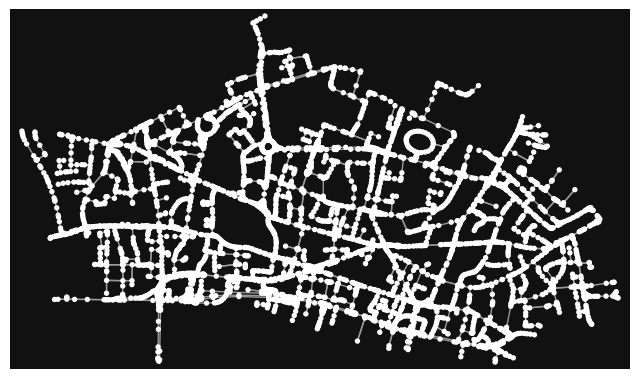

In [66]:
place = 'City of London, Greater London, England, United Kingdom'

# I'm setting simplify false here to show how osmnx clean the networks topology
G = ox.graph_from_place(place, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G)

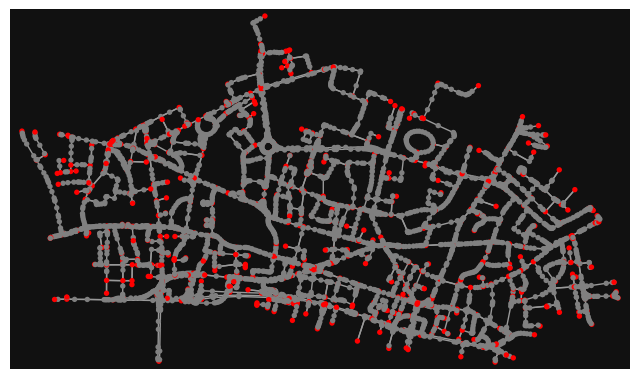

In [67]:
nc = ['r' if ox.simplification._is_endpoint(G, node, None, None) else 'grey' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

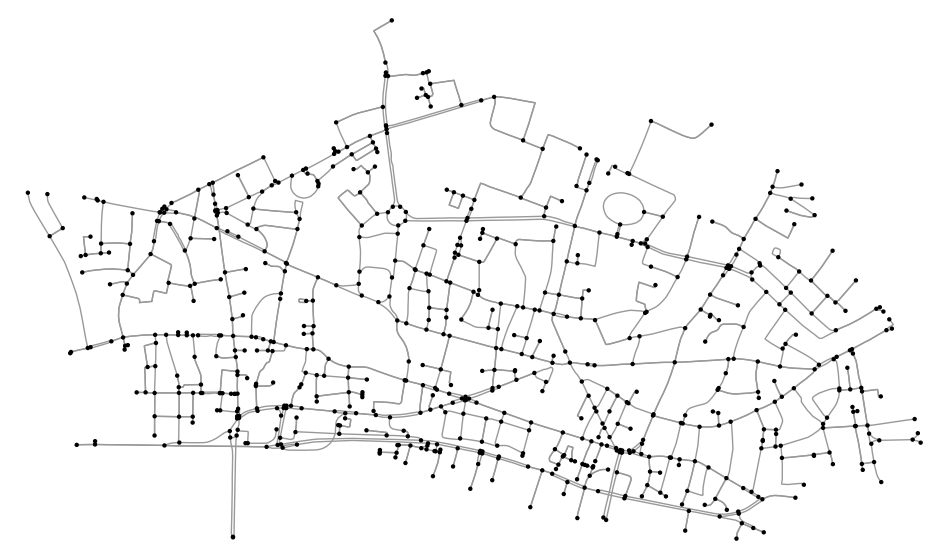

In [68]:
# simplify the network
fig, ax = plt.subplots(figsize=(12,7))
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, 
                        node_color='k',
                        node_size = 10,
                        ax=ax)

In [69]:
tube = ox.features.features_from_place(place, tags={'railway': True})
tube = tube[~tube['name'].isna()]

In [70]:
# let's check on the data
tube = tube[(tube['geometry'].type=='Point') & (tube['railway']=='stop') & (~tube['name'].isna())]
tube = tube[['name', 'operator', 'subway', 'geometry']]
tube.head(10)

name              operator subway  \
element id                                                                 
node    18395697                   Monument    London Underground    yes   
        64772416              Cannon Street    London Underground    yes   
        64775110              Mansion House  Transport for London    yes   
        181505582                  Barbican    London Underground    yes   
        1271716489  London Liverpool Street                   NaN    NaN   
        1271716490  London Liverpool Street                   NaN    NaN   
        1271716491  London Liverpool Street                   NaN    NaN   
        1271716492  London Liverpool Street                   NaN    NaN   
        1271716493  London Liverpool Street                   NaN    NaN   
        1271716494  London Liverpool Street                   NaN    NaN   

                                     geometry  
element id                                     
node    18395697    POINT (-0.08606 51.51069)  
        64772416    POINT (-0.09032 51.51137)  
        64775110    POINT (-0.09521 51.51182)  
        181505582    POINT (-0.09873 51.5202)  
        1271716489  POINT (-0.08077 51.51781)  
        1271716490  POINT (-0.08216 51.51808)  
        1271716491  POINT (-0.08053 51.51776)  
        1271716492  POINT (-0.08195 51.51805)  
        1271716493  POINT (-0.08232 51.51811)  
        1271716494   POINT (-0.0814 51.51794)

In [71]:
# remove Platform 1 from the name
tube['name'] = tube['name'].apply(lambda x: x.replace("Platform 1", "").strip())

# get the x,y from the geometries
tube['x'] = tube['geometry'].apply(lambda x: x.x)
tube['y'] = tube['geometry'].apply(lambda x: x.y)

# compute the average x,y per stop name
tube = tube.groupby('name', as_index=False).agg({'x':'mean', 'y':'mean'})
# reconstruct the gdf
tube = gpd.GeoDataFrame(tube, geometry=gpd.points_from_xy(tube['x'], tube['y']), crs=4326)

In [72]:
print(tube['name'].unique())

['Aldgate' 'Bank' 'Barbican' 'Blackfriars' 'Cannon Street' 'Chancery Lane'
 'City Thameslink' 'Liverpool Street' 'London Blackfriars'
 'London Fenchurch Street' 'London Liverpool Street' 'Mansion House'
 'Monument' 'Moorgate' "St. Paul's" 'Tower Gateway'
 'Tower Gateway Platform 2']


In [73]:
# Step 1: Get coordinates of "Bank"
bank_geom = tube[tube['name'] == 'Bank'].geometry.values[0]
bank_xy = (bank_geom.x, bank_geom.y)

# Step 2: Get nearest node in road network to "Bank"
bank_node = ox.nearest_nodes(G, bank_xy[0], bank_xy[1])

# Step 3: Exclude "Bank" from the candidate list
tube_bank = tube[tube['name'] != 'Bank'].copy()

# Step 4: Get each tube stop's nearest road node
tube_bank['node'] = tube_bank.geometry.apply(lambda point: ox.nearest_nodes(G, point.x, point.y))

# Step 5: Calculate shortest path length from Bank node to each station node
dist_dict = nx.single_source_dijkstra_path_length(G, bank_node, weight='length')
tube_bank['distance_from_bank'] = tube_bank['node'].map(dist_dict)

# Step 6: Sort and display top 3 nearest stations
nearest3_bank = tube_bank.sort_values('distance_from_bank').head(3)[['name', 'distance_from_bank']]

# Step 7: Calculate walking time using speed of 1.33 m/s (4.8 km/h)
walking_speed_mps = 1.33

nearest3_bank['walk_time_sec'] = nearest3_bank['distance_from_bank'] / walking_speed_mps
nearest3_bank['walk_time_min'] = nearest3_bank['walk_time_sec'] / 60

display(nearest3_bank)


name  distance_from_bank  walk_time_sec  walk_time_min
12       Monument          407.210751     306.173497       5.102892
11  Mansion House          655.731350     493.031090       8.217185
4   Cannon Street          846.142702     636.197520      10.603292

Bank to Mansion House | Distance: 655.731349812952


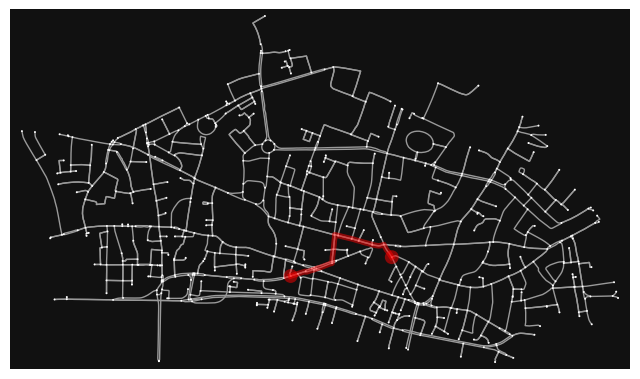

In [74]:
# shortest path on the network from Upminster to Emerson Park
o = ox.nearest_nodes(G, tube[tube['name']=='Bank'].iloc[0]['x'], tube[tube['name']=='Bank'].iloc[0]['y'])
d = ox.nearest_nodes(G, tube[tube['name']=='Mansion House'].iloc[0]['x'], tube[tube['name']=='Mansion House'].iloc[0]['y'])
# get the shortest path
path = nx.shortest_path(G, o, d, weight='length')

print(f"Bank to Mansion House | Distance: {nx.shortest_path_length(G, o, d, weight='length')}")
fig, ax = ox.plot_graph_route(G, path, node_size=2)

In [75]:
# Step 1: Get coordinates of "Monument"
monument_geom = tube[tube['name'] == 'Monument'].geometry.values[0]
monument_xy = (monument_geom.x, monument_geom.y)

# Step 2: Get nearest node in road network to "Monument"
monument_node = ox.nearest_nodes(G, monument_xy[0], monument_xy[1])

# Step 3: Exclude "Monument" from candidate list
tube_mon = tube[tube['name'] != 'Monument'].copy()

# Step 4: Get each station's nearest road node
tube_mon['node'] = tube_mon.geometry.apply(lambda point: ox.nearest_nodes(G, point.x, point.y))

# Step 5: Compute shortest path distance from Monument to each node
dist_dict_mon = nx.single_source_dijkstra_path_length(G, monument_node, weight='length')
tube_mon['distance_from_monument'] = tube_mon['node'].map(dist_dict_mon)

# Step 6: Sort and show top 3 closest stations
nearest3_monument = tube_mon.sort_values('distance_from_monument').head(3)[['name', 'distance_from_monument']]

# Step 7: Calculate walking time using speed of 1.33 m/s (4.8 km/h)
walking_speed_mps = 1.33

nearest3_monument['walk_time_sec'] = nearest3_monument['distance_from_monument'] / walking_speed_mps
nearest3_monument['walk_time_min'] = nearest3_monument['walk_time_sec'] / 60

# Display final table
display(nearest3_monument)


name  distance_from_monument  walk_time_sec  walk_time_min
1            Bank              288.610143     217.000108       3.616668
4   Cannon Street              618.630542     465.135746       7.752262
11  Mansion House              668.183878     502.393893       8.373232

Monument to Cannon Street | Distance: 618.6305423126195


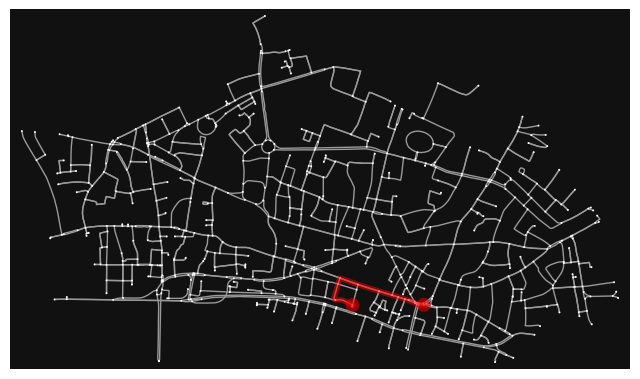

In [76]:
# shortest path on the network from Upminster to Emerson Park
o = ox.nearest_nodes(G, tube[tube['name']=='Monument'].iloc[0]['x'], tube[tube['name']=='Monument'].iloc[0]['y'])
d = ox.nearest_nodes(G, tube[tube['name']=='Cannon Street'].iloc[0]['x'], tube[tube['name']=='Cannon Street'].iloc[0]['y'])
# get the shortest path
path = nx.shortest_path(G, o, d, weight='length')

print(f"Monument to Cannon Street | Distance: {nx.shortest_path_length(G, o, d, weight='length')}")
fig, ax = ox.plot_graph_route(G, path, node_size=2)

In [77]:
import shapely.geometry

# Step 1: Get geometries of Bank and Monument
bank_geom = tube[tube['name'] == 'Bank'].geometry.values[0]
monument_geom = tube[tube['name'] == 'Monument'].geometry.values[0]

# Step 2: Create a new point at the midpoint between Bank and Monument
combined_point = shapely.geometry.Point(
    (bank_geom.x + monument_geom.x) / 2,
    (bank_geom.y + monument_geom.y) / 2
)

# Step 3: Get nearest node in road network to this combined location
combined_node = ox.nearest_nodes(G, combined_point.x, combined_point.y)

# Step 4: Exclude Bank and Monument from candidate tube stations
tube_combined = tube[~tube['name'].isin(['Bank', 'Monument'])].copy()

# Step 5: Get road node for each tube stop
tube_combined['node'] = tube_combined.geometry.apply(lambda point: ox.nearest_nodes(G, point.x, point.y))

# Step 6: Compute distance from combined node to each station
dist_dict = nx.single_source_dijkstra_path_length(G, combined_node, weight='length')
tube_combined['distance_from_combined'] = tube_combined['node'].map(dist_dict)

# Step 7: Sort and extract top 3 nearest stations
nearest3_combined = tube_combined.sort_values('distance_from_combined').head(3)[['name', 'distance_from_combined']]

# Step 8: Add walking time (in seconds and minutes)
walking_speed_mps = 1.33
nearest3_combined['walk_time_sec'] = nearest3_combined['distance_from_combined'] / walking_speed_mps
nearest3_combined['walk_time_min'] = nearest3_combined['walk_time_sec'] / 60

# Display result
display(nearest3_combined)


name  distance_from_combined  walk_time_sec  \
11            Mansion House              804.372357     604.791246   
9   London Fenchurch Street              880.099353     661.728837   
10  London Liverpool Street              939.771527     706.595133   

    walk_time_min  
11      10.079854  
9       11.028814  
10      11.776586

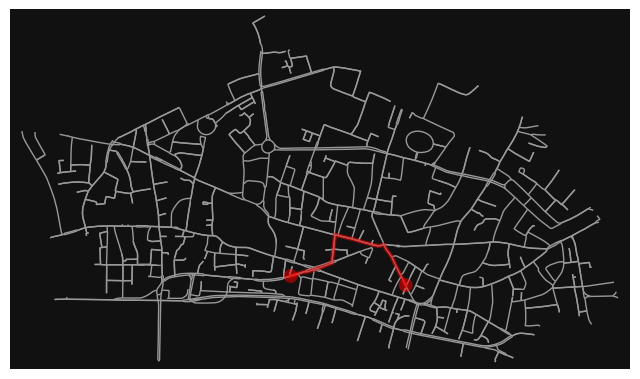

In [93]:
bank_geom = tube[tube['name'] == 'Bank'].geometry.values[0]
monument_geom = tube[tube['name'] == 'Monument'].geometry.values[0]
center_point = shapely.geometry.Point(
    (bank_geom.x + monument_geom.x) / 2,
    (bank_geom.y + monument_geom.y) / 2
)


center_node = ox.nearest_nodes(G, center_point.x, center_point.y)


target_name = 'Mansion House'
target_geom = tube[tube['name'] == target_name].geometry.values[0]
target_node = ox.nearest_nodes(G, target_geom.x, target_geom.y)


path = nx.shortest_path(G, center_node, target_node, weight='length')
path_length = nx.shortest_path_length(G, center_node, target_node, weight='length')


fig, ax = ox.plot_graph_route(G, path, route_color='red', route_linewidth=3,
                              node_size=0, show=False, close=False,figsize=(8, 8))


#ax.text(center_point.x, center_point.y, 'Bank & Monument', fontsize=12, color='blue',
        #bbox=dict(facecolor='white', alpha=0.8))

#ax.text(target_geom.x, target_geom.y, target_name, fontsize=12, color='green',
        #bbox=dict(facecolor='white', alpha=0.8))


mid_x = (center_point.x + target_geom.x) / 2
mid_y = (center_point.y + target_geom.y) / 2
#ax.text(mid_x, mid_y, f'Distance: {int(path_length)} m', fontsize=10,
        #bbox=dict(facecolor='white', alpha=0.6))

#plt.title("Shortest Walking Path: Bank & Monument → Mansion House", fontsize=14)
plt.show()